# CantBot, tu asesor de viajes por Cantabria

Este notebook documenta el diseño, entrenamiento e implementación de CanBot, un chatbot híbrido desarrollado para recomendar experiencias turísticas en Cantabria.

El sistema combina técnicas clásicas de Aprendizaje Automático, como la regresión logística, con otras de Aprendizaje Profundo, mediante modelos de redes neuronales con embeddings contextuales basados en codificadores tipo Transformer (Sentence-BERT) y modelos generativos de lenguaje natural (LLM) para ofrecer una experiencia de usuario eficiente, coherente y personalizada.

CanBot utiliza un árbol de decisión de dos niveles:

En el nivel 1, un clasificador supervisado basado en regresión logística o sustentado en una red neuronal entrenada con embeddings contextuales (según la preferencia), identifica la categoría general a la que pertenece la intención del usuario ("naturaleza", "cultura", "gastronomía", "espectáculos en vivo" o "compras").

En el nivel 2, un modelo generativo LLM, afinado de Meta-Llama 3.1, produce recomendaciones específicas correspondientes a una determinada subcategoría, adaptadas al lenguaje natural del usuario.

En caso de que el modelo del primer nivel no identifique la entrada del usuario, se pone en acción el modelo del segundo nivel mediante un mecanismo de fallback.

Además, en el notebook se documentan:

a) Visualizaciones exploratorias del corpus sintético utilizado para el entrenamiento.

b) Pruebas experimentales con modelos alternativos basados en redes neuronales simples y con el mencionado modelo afinado de Sentence-BERT, `hiiamsid/sentence_similarity_spanish_es` para la clasificación de las 15 subcategorías y las cinco raíz del árbol de decisión.

c) Evaluaciones cuantitativas, mediante métricas estándar de clasificación como precisión, recall y F1-score y cualitativas, a través de testeo con frases reales y ambiguas.

El objetivo final es ofrecer una solución modular, flexible y eficiente para sistemas de recomendación turística basados en conversaciones directas con los usuarios.



## Fase1: Diseño conceptual y procedimiento

###  1. a)  Importación de librerías necesarias

In [ ]:
# Visualización y gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from graphviz import Digraph
from IPython.display import Image

# Preprocesamiento de texto
from sklearn.feature_extraction.text import TfidfVectorizer


# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Modelado y entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Evaluación
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Numérico
import numpy as np



###1. b) Definición del árbol de decisión

Un árbol de decisión es un algoritmo de aprendizaje supervisado empleado, para, entre otras tareas, la clasificación.

Tiene una estructura jerárquica, que consta de un nodo raíz, ramas, nodos internos y nodos hoja.

Esta estructura es adecuada para la creación de un chatbot consultor de viajes breves como CanBoT, ya que guía al usuario a través de preguntas, hasta una recomendación final, de modo que cada elección determina la siguiente pregunta.

De este modo, el árbol diseñado en el proyecto ayuda al usuario a elegir una experiencia turística personalizada en Cantabria, según sus preferencias: "naturaleza", "cultura", "gastronomía", "espectáculos en vivo" o "compras".

Su estructura es simétrica y consta de:

a) un nodo raíz: la pregunta inicial: "¿Qué tipo de experiencia te gustaría vivir en Cantabria?"

b) 5 nodos principales: "naturaleza", "cultura", "gastronomía", "espectáculos en vivo", "compras"

c) 15 subnodos (3 por cada nodo principal), correspondientes a las elecciones de segundo nivel: "montaña", "costa" y "parques naturales" en "naturaleza", por ejemplo.

Esta simetría permite un diseño balanceado que facilita tanto la generación de datos como el entrenamiento de modelos de clasificación.

El siguiente bloque de código representa el árbol de decisión principal del chatbot CanBot en forma de un diccionario anidado de Python. Este diccionario utiliza una estructura basada en claves y valores en las que:

Las claves ("question", "options") definen el contenido y las posibles elecciones en cada nivel del árbol.

Los valores pueden ser cadenas de texto (en los nodos finales con recomendaciones) o, a su vez, otros diccionarios anidados que contienen nuevas preguntas y opciones.

La clave principal "question" se utiliza para mostrar la pregunta correspondiente al usuario en cada nodo. La clave "options" contiene un nuevo diccionario en el que cada clave secundaria representa una posible respuesta y cada valor asociado lleva a otro nodo con su propia pregunta o directamente a una recomendación final (cuando se trata de un nodo hoja).


In [ ]:
decision_tree = {
    "question": "¿Qué tipo de experiencia te gustaría vivir en Cantabria?",
    "options": {
        "naturaleza": {
            "question": "¿Prefieres montaña, costa o parques naturales?",
            "options": {
                "montaña": "recomienda: Ruta del Cares en el límite con Asturias",
                "costa": "recomienda: Surf en Somo con tabla alquilada",
                "parques naturales": "recomienda: Visita ornitológica a las Marismas de Santoña."
            }
        },
        "cultura": {
            "question": "¿Prefieres historia, arte o tradiciones vivas?",
            "options": {
                "historia": "recomienda: Ruta guiada a Comillas y Neocueva de Altamira",
                "arte": "recomienda: Centro Botín en Santander",
                "tradiciones vivas": "recomienda: Visita el carnaval de La Vijanera"
            }
        },
        "gastronomía": {
            "question": "¿Prefieres carne, mariscos o dulces típicos?",
            "options": {
                "carne": "recomienda: Chuletón en un restaurante de San Roque",
                "mariscos": "recomienda: Mariscada en Castro Urdiales",
                "dulces típicos": "recomienda: Sobaos y quesadas en Vega de Pas"
            }
        },
        "espectáculos en vivo": {
            "question": "¿Prefieres música, teatro o encuentros literarios?",
            "options": {
                "música": "recomienda: Festival de verano en la campa de La Magdalena",
                "teatro": "recomienda: Obra clásica en el Palacio de Festivales",
                "encuentros literarios": "recomienda: Lectura o presentación de autor en la Universidad Internacional Menéndez Pelayo."
            }
        },
        "compras": {
            "question": "¿Prefieres productos tradicionales, modernos o pequeños souvenirs?",
            "options": {
                "tradicionales": "recomienda: Miel, quesos y sobaos en mercado de Potes",
                "modernos": "recomienda: Diseño local en tiendas boutique de Santander",
                "souvenirs": "recomienda: Pequeños recuerdos típicos en las tiendas de Santillana del Mar."
            }
        }
    }
}


### 1. c) Ejemplos de diálogos por nodo

A continuación se muestran tres ejemplos representativos de diálogos posibles por nodo principal:

```txt

Nodo: naturaleza

Diálogo 1
-Usuario: Me gustaría hacer senderismo o disfrutar del paisaje natural.
-Chatbot: ¡Perfecto! Te recomiendo una experiencia en la naturaleza como la Ruta del Cares en el límite con Asturias.

Diálogo 2
-Usuario: Busco relajarme en la playa y hacer algo de deporte.
-Chatbot: Excelente elección. Te propongo practicar Surf en Somo con una tabla alquilada.

Diálogo 3
-Usuario: Me interesa caminar por senderos tranquilos y ver aves.
-Chatbot: Entonces puedes realizar una visita ornitológica en el Parque Natural de las Marismas de Santoña.

Nodo: cultura

Diálogo 1
-Usuario: Quiero conocer la historia y el patrimonio local.
-Chatbot: Te recomiendo visitar la Neocueva de Altamira o el Centro Botín, si prefieres arte.

Diálogo 2
-Usuario: Busco un plan relacionado con el arte o la historia.
-Chatbot: Entonces podrías disfrutar de un recorrido cultural por Santander o visitar exposiciones locales.

Diálogo 3
-Usuario: Me gustaría asistir a una fiesta tradicional con música y trajes típicos.
-Chatbot: Puedes visitar Silió en enero y vivir La Vijanera, una de las celebraciones más antiguas de Cantabria.

Nodo: gastronomía

Diálogo 1
-Usuario: Me interesa probar platos de cocina tradicionales.
-Chatbot: ¡Buena idea! Puedes disfrutar de un buen chuletón en San Roque.

Diálogo 2
-Usuario: Quiero hacer turismo con amigos y celebrar un aniversario con una comida.
-Chatbot: Entonces no puedes perderte una mariscada en Castro Urdiales.

Diálogo 3
-Usuario: ¿Dónde puedo probar algo dulce típico de la zona?
-Chatbot: Te sugiero saborear una quesada pasiega en Vega de Pas.

Nodo: espectáculos en vivo

Diálogo 1
-Usuario: Busco música o algo cultural en directo.
-Chatbot: Te recomiendo el festival de verano en la campa de La Magdalena.

Diálogo 2
-Usuario: Quiero asistir a una obra de teatro clásico.
-Chatbot: Puedes elegir entre conciertos locales o una función teatral con artistas cántabros en el Palacio de Festivales.

Diálogo 3
-Usuario: Me gustaría escuchar poesía en un ambiente tranquilo.
-Chatbot: Te recomiendo la lectura o presentación de autor en la Universidad Internacional Menéndez Pelayo.

Nodo: compras

Diálogo 1
-Usuario: Me interesan los productos artesanales locales elaborados con buenas materias primas.
-Chatbot: Te sugiero comprar sobaos y quesadas en Vega de Pas.

Diálogo 2
-Usuario: Quiero comprar algo artesano moderno con esencia local para regalar.
-Chatbot: Entonces visita las tiendas boutique en Santander con diseño contemporáneo cántabro.

Diálogo 3
-Usuario: Estoy buscando un recuerdo pequeño para llevar a mi familia.
-Chatbot: Puedes encontrar souvenirs típicos como imanes o llaveros en las tiendas de Santillana del Mar.

```

### 1. d) Diagrama del árbol de decisión de CanBot

Con el objetivo de visualizar de forma clara la lógica de decisión implementada en CanBot, en la siguiente celda se define la función recursiva llamada` add_nodes()`, que recorre el árbol de decisión y genera su representación gráfica mediante la librería Graphviz.

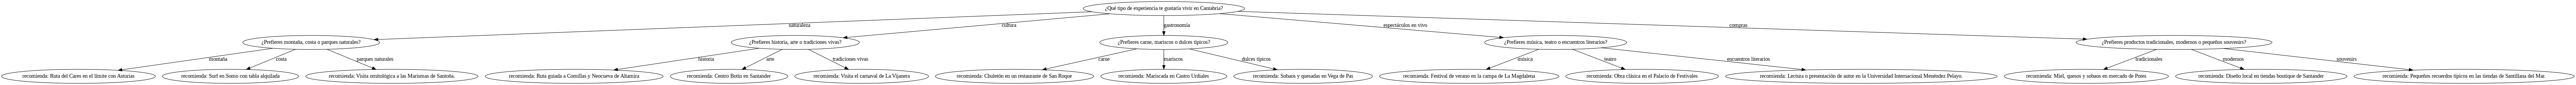

In [ ]:
counter = 0

def add_nodes(tree, graph, parent_id=None, edge_label=""):
    global counter
    current_id = f"node{counter}"
    counter += 1

    if isinstance(tree, dict):
        graph.node(current_id, tree["question"])
        if parent_id is not None:
            graph.edge(parent_id, current_id, label=edge_label)
        for option, subtree in tree.get("options", {}).items():
            add_nodes(subtree, graph, current_id, option)
    else:
        graph.node(current_id, tree)
        if parent_id is not None:
            graph.edge(parent_id, current_id, label=edge_label)

mindmap = Digraph("DecisionTree", format="png")
mindmap.attr(rankdir="TB")  # Top to Bottom

add_nodes(decision_tree, mindmap)

mindmap.render("chatbot_mindmap", format="png", cleanup=True)
Image(filename="chatbot_mindmap.png")


## Fase 2: Regresión logística básica

La regresión logística es un modelo de clasificación supervisada que predice la probabilidad de que una entrada pertenezca a una clase determinada.

Se basa en una combinación lineal de las variables de entrada a la que se aplican funciones como `softmax` (en casos multiclase como este), para, en la salida, transformar esas combinaciones en probabilidades entre 0 y 1.


###2. a) Creación de un dataset

A continuación se ha construido un dataset sintético en forma de un diccionario de Python, `examples_dict,` en el que cada clave representa una categoría o subcategoría del árbol de decisión y cada valor asociado es una lista de treinta frases por categoría y subcategoría, que tratan de reflejar peticiones naturales de un usuario. De esta manera, se consigue un corpus equilibrado, que no muestre sesgos hacia ninguna clase.

El dataset contiene un total de 600 ejemplos, distribuidos equitativamente en 20 clases (5 categorías principales y 15 subcategorías), con 30 ejemplos por clase, lo que lo convierte en un corpus balanceado.

Asimismo, en lugar de construir un corpus limitado con frases genéricas por categoría principal, se ha optado por la estrategia de que frases específicas de cada subcategoría del árbol (por ejemplo, "montaña", "parques naturales", "dulces típicos", "souvenirs", etc.) estén representadas también en las categorías principales para que, de este modo, el dataset sea más representativo para entrenar al modelo de clasificación.

Además, el diseño modular del dataset facilita su ampliación con nuevas categorías, subcategorías o ejemplos adicionales sin afectar a la estructura general del sistema.


In [ ]:
examples_dict = {
    "naturaleza": [
        "Quiero relajarme en la playa rodeado de naturaleza",
        "Me interesa una experiencia de naturaleza junto al mar",
        "Busco estar en contacto con la naturaleza costera",
        "Prefiero disfrutar de la naturaleza en la costa cántabra",
        "Quiero respirar aire natural junto a la playa",
        "Me encanta caminar por playas tranquilas en entornos naturales",
        "Busco naturaleza y mar en una escapada relajante",
        "Quiero una experiencia al aire libre en la playa",
        "Disfruto de la naturaleza cerca del mar",
        "Quiero sentir la brisa marina en un entorno natural",
        "Quiero hacer senderismo en la montaña y conectar con la naturaleza",
        "Me atrae la naturaleza salvaje de las montañas",
        "Prefiero paisajes montañosos llenos de vegetación",
        "Quiero subir una montaña rodeado de naturaleza",
        "Me interesa una ruta natural por los picos de Cantabria",
        "Busco aventura y naturaleza en las zonas montañosas",
        "Quiero perderme en la naturaleza de las montañas",
        "Disfruto del silencio natural en lo alto de una montaña",
        "Planeo una escapada de naturaleza en zonas elevadas",
        "Me gusta el contacto con la montaña y su naturaleza",
        "Quiero visitar parques naturales con senderos tranquilos",
        "Busco una experiencia de naturaleza en un espacio protegido",
        "Quiero observar aves en un parque natural",
        "Prefiero naturaleza accesible en zonas protegidas",
        "Me interesa la biodiversidad de los parques naturales",
        "Quiero caminar por pasarelas de madera en un parque natural",
        "Estoy buscando una zona de naturaleza sin aglomeraciones",
        "Quiero descubrir la flora y fauna de un parque natural",
        "Me interesa la tranquilidad de un entorno natural cuidado",
        "Planeo un día en la naturaleza dentro de un parque cántabro"
    ],
    "cultura": [
        "Quiero conocer la historia y el patrimonio local",
        "Me gustaría visitar museos o sitios culturales",
        "Busco un plan relacionado con el arte o la historia",
        "Me interesan los pueblos con valor histórico",
        "Quiero ver arquitectura y exposiciones",
        "Me gusta aprender cosas nuevas sobre la región",
        "Estoy buscando un plan cultural",
        "Prefiero una experiencia educativa e interesante",
        "Quiero recorrer sitios históricos",
        "Me interesan los aspectos culturales y el arte del lugar",
        "Quiero caminar por cascos antiguos",
        "Busco arte, museos y edificios históricos",
        "Me gustaría hacer una ruta cultural guiada",
        "Quiero empaparme de la historia de Cantabria y sus tradiciones",
        "Voy por los monumentos y la cultura local",
        "Quiero un plan enriquecedor y con contenido cultural",
        "Estoy interesado en la arquitectura de la zona",
        "Me gusta el turismo de cultura, el arte y las tradiciones vivas",
        "Prefiero conocer tradiciones y costumbres",
        "Quiero visitar exposiciones o galerías",
        "Me interesa la historia y el arte, así como las tradiciones vivas",
        "Planeo un viaje enfocado en cultura",
        "Me encanta conocer la identidad de cada sitio",
        "Busco algo más profundo, como arte o historia",
        "Quiero sentir el alma cultural del lugar",
        "Prefiero el arte a la aventura",
        "Estoy buscando una experiencia patrimonial",
        "Quiero explorar el lado cultural de Cantabria",
        "Me interesa lo artístico, no lo deportivo",
        "Voy a hacer turismo de cultura, arte, historia, folklore y tradiciones populares."
    ],
    "gastronomía": [
        "Quiero disfrutar de la comida típica de Cantabria: marisco, carne, dulces",
        "Me interesa probar platos tradicionales",
        "Estoy viajando por el placer de comer bien",
        "Quiero hacer turismo gastronómico",
        "Voy buscando buenos restaurantes",
        "Me encanta descubrir la cocina local",
        "Busco una experiencia con sabor",
        "Quiero probar productos típicos como sobaos o rabas",
        "Prefiero un plan donde se coma bien",
        "Me atraen las recetas de la zona",
        "Quiero probar mariscos o carnes regionales",
        "Me interesa la gastronomía del norte de España",
        "Quiero comer platos que no encuentro en casa como buen marisco",
        "Busco algo sabroso y bien presentado",
        "Me gustaría visitar un mercado gastronómico",
        "Voy por el queso, la miel y la sidra",
        "Quiero que el viaje sea una experiencia culinaria",
        "Estoy en modo food lover",
        "Me atrae todo lo que sea comer rico y local",
        "Quiero cenar en una posada típica",
        "Me encanta probar nuevos sabores",
        "Busco un menú que represente la región",
        "Quiero almorzar algo típico de la zona",
        "Planeo hacer catas o degustaciones de queso, carne, langosta y sobaos",
        "Quiero saborear productos autóctonos: carne, pescado",
        "Me interesa conocer la tradición culinaria cántabra",
        "Voy en busca de comida auténtica",
        "Estoy explorando Cantabria con el paladar:dulces típicos me encantan",
        "Quiero probar algo diferente y local",
        "Elijo mi viaje por la gastronomía"
    ],
    "espectáculos en vivo": [
        "Quiero asistir a un evento en vivo, aun encuentro literario",
        "Busco música, conciertos al aire libre, teatro o algo cultural en directo",
        "Me interesa ver espectáculos en Cantabria",
        "¿Qué conciertos o funciones hay en la zona?",
        "Prefiero un plan con artistas en vivo",
        "Me gustan los eventos con público y escena",
        "Estoy buscando algo como teatro o música",
        "Quiero ir a ver una obra o concierto",
        "Planeo una noche cultural con espectáculo",
        "¿Hay eventos musicales esta semana?",
        "Quiero ver algo en vivo en un escenario",
        "Busco un plan diferente con arte en directo",
        "Me encanta disfrutar de la música en vivo",
        "Me interesa el teatro regional",
        "Quiero un espectáculo para disfrutar en pareja",
        "Prefiero entretenimiento en vivo que museos",
        "Voy a Cantabria y quiero ver algo en directo",
        "¿Dónde hay funciones en vivo por la noche?",
        "Me interesa la oferta escénica de la zona",
        "Quiero un plan cultural y divertido",
        "Me gusta escuchar música con buena acústica",
        "Me interesa el humor en directo o conciertos",
        "Voy a incluir un show en mi viaje",
        "Quiero sentir el ambiente de un espectáculo real",
        "Estoy buscando una agenda de espectáculos, de teatro",
        "Quiero algo de teatro, música o danza",
        "Me interesa la programación artística local",
        "Prefiero lo escénico a lo museístico",
        "Quiero algo animado, como una función",
        "Estoy buscando una propuesta en vivo y cultural"
    ],
    "compras": [
        "Quiero comprar cosas típicas de Cantabria: souvenirs",
        "Me interesa la artesanía local",
        "Estoy buscando souvenirs o regalos",
        "Quiero hacer compras en tiendas de la zona de moda, algo moderno",
        "Prefiero productos locales como recuerdo",
        "Me gustaría llevarme algo especial, moderno, de recuerdo",
        "Estoy buscando cosas hechas en Cantabria",
        "Quiero recorrer tiendas con encanto",
        "Busco productos artesanales",
        "Voy a llevarme un recuerdo del viaje",
        "Quiero comprar alimentos típicos o artesanías",
        "Estoy interesado en tiendas tradicionales o modernas",
        "Busco un detalle bonito para regalar",
        "Me gusta explorar mercados locales",
        "Quiero comprar directamente a los productores",
        "Voy por miel, quesos, sobaos u otros productos típicos",
        "Me interesa llevar algo único",
        "Prefiero llevar recuerdos en forma de objetos",
        "Quiero algo bonito para mí o para regalar",
        "Me gustaría algo moderno con esencia local",
        "Estoy buscando arte local o diseño",
        "Me interesa lo hecho a mano: regalos tradicionales",
        "Quiero llevarme una pieza de artesanía cántabra",
        "Quiero algo de diseño cántabro contemporáneo",
        "Me gusta comprar productos con identidad",
        "Busco una tienda con regalos originales",
        "Quiero comprar moda o decoración local",
        "Voy un recuerdo bonito típico",
        "Me gustaría encontrar objetos únicos y bellos: modernos",
        "Quiero algo útil, bonito y típico"
    ],
    "montaña": [
        "Quiero hacer senderismo en la montaña, plena naturaleza",
        "Me interesa la montaña y el bosque",
        "Prefiero un plan de aventura en la sierra",
        "Me gustaría recorrer rutas montañosas",
        "Busco aire puro y vistas desde la cima",
        "Quiero perderme por caminos de montaña",
        "¿Qué excursiones hay por la montaña?",
        "Quiero hacer una caminata por los Picos de Europa",
        "Me encanta subir cuestas y hacer trekking",
        "Voy buscando naturaleza de altura",
        "Quiero ver animales y árboles en la montaña",
        "Busco paz en un entorno montañoso",
        "Prefiero el verde de los montes al mar",
        "Quiero sentir la brisa de la montaña",
        "Ruta con vistas panorámicas de montaña, ¿alguna?",
        "Me gusta el desafío físico de las montañas",
        "Planeo escaparme a una zona montañosa",
        "Montaña, niebla, silencio... eso quiero",
        "Estoy buscando paisajes montañosos para explorar",
        "Quiero caminar por senderos entre pinos",
        "Busco un lugar fresco con senderos en altura",
        "Me interesan rutas rurales por zonas montañosas",
        "Quiero desconectar subiendo montañas",
        "Estoy organizando una salida de montaña",
        "Busco aventura al aire libre en zona elevada",
        "Quiero explorar valles y picos",
        "Viajo para ver montañas y respirar tranquilidad",
        "Quiero huir del calor y caminar en montaña",
        "Me gusta el silencio de la naturaleza en altura",
        "Estoy buscando una experiencia de altura y bosque"
    ],
    "costa": [
        "Quiero relajarme en la playa",
        "Prefiero la brisa marina y el sonido de las olas",
        "Me encanta caminar por la orilla",
        "Busco algo tranquilo frente al mar",
        "Quiero tomar el sol en la costa",
        "¿Qué playas me recomiendas en Cantabria?",
        "Me gustaría hacer surf o nadar en el mar",
        "Quiero disfrutar de la arena y el agua",
        "Elijo siempre mar en lugar de montaña",
        "Quiero desconectar mirando el océano",
        "Plan costero: mar, viento y libertad",
        "Estoy buscando calas bonitas para visitar",
        "Me gusta pasear por paseos marítimos",
        "Busco un paisaje costero para relajarme",
        "Quiero ver atardeceres en la playa",
        "Me interesa una escapada a la costa",
        "Voy en busca de buenas playas",
        "Amo el mar y quiero un plan cerca del agua",
        "Quiero respirar aire salado y mojar los pies",
        "Prefiero la costa con vistas al horizonte",
        "Quiero escuchar las olas mientras descanso",
        "Busco un entorno marino sin aglomeraciones",
        "Me gusta ver barcas y pueblos costeros",
        "Quiero caminar descalzo por la playa",
        "Estoy pensando en un plan tranquilo frente al mar",
        "Quiero disfrutar del mar con calma",
        "Viajo para ver playas y acantilados",
        "Quiero explorar la costa cántabra en plan relax",
        "Busco una escapada a la orilla del mar",
        "Estoy soñando con una tarde junto al mar"
    ],
    "parques naturales": [
        "Quiero visitar un parque natural donde pueda observar aves y relajarme en la naturaleza",
        "Busco un lugar protegido con senderos suaves y paisaje tranquilo para desconectar",
        "Me interesa explorar ecosistemas naturales como bosques, humedales o reservas en Cantabria",
        "Quiero caminar por un entorno natural sin masificaciones",
        "Estoy buscando una experiencia tranquila dentro de un parque natural",
        "Quiero hacer una ruta sencilla por un entorno natural bien conservado",
        "Me atraen los espacios protegidos con diversidad de fauna y flora",
        "Busco una zona donde pueda ver aves en libertad",
        "Prefiero un paseo por un parque natural a un lugar turístico",
        "Quiero un día de excursión suave rodeado de naturaleza",
        "Me gustaría pasar el día en un parque con miradores naturales",
        "Estoy interesado en conocer los humedales de Cantabria",
        "Quiero hacer fotos de paisajes tranquilos y sin aglomeraciones",
        "Busco contacto con la biodiversidad sin necesidad de hacer deporte",
        "Me encanta caminar por senderos bien señalizados en entornos verdes",
        "Quiero descubrir parques naturales con zonas de interpretación",
        "Me gustaría descansar en un área natural alejada del ruido",
        "Prefiero rutas accesibles con vistas naturales",
        "Busco una escapada ecológica de bajo impacto",
        "Me atrae la idea de estar en una reserva natural",
        "Quiero oír el canto de los pájaros y ver árboles autóctonos",
        "Deseo encontrar un rincón verde para desconectar del estrés",
        "Me interesa hacer turismo sostenible en zonas protegidas",
        "Busco tranquilidad en entornos donde se respete la naturaleza",
        "Quiero caminar junto a un río en un parque natural",
        "Estoy planeando visitar una zona natural con pasarelas de madera",
        "Me gustaría hacer un recorrido interpretativo por un parque cántabro",
        "Quiero ver cómo se protege la fauna local",
        "Me interesan los itinerarios guiados en espacios naturales",
        "Prefiero disfrutar del paisaje sin necesidad de grandes esfuerzos"
    ],
    "historia": [
        "Quiero conocer la historia local",
        "Me interesan los lugares con valor histórico",
        "Busco una experiencia cultural relacionada con el pasado",
        "Me gustaría visitar museos históricos",
        "Quiero aprender sobre la historia de Cantabria",
        "¿Dónde puedo ver construcciones antiguas?",
        "Busco patrimonio histórico para visitar",
        "Me interesa el turismo cultural enfocado en historia",
        "Quiero conocer los pueblos con pasado interesante",
        "Me gustan los relatos del pasado",
        "Quiero ver ruinas o edificaciones antiguas",
        "Planeo una visita a sitios históricos",
        "Quiero aprender sobre cómo vivía la gente antes",
        "Busco monumentos y sitios históricos para ver",
        "¿Qué lugares históricos recomiendas?",
        "Voy a Cantabria y quiero empaparme de historia",
        "Me atrae todo lo relacionado con arqueología e historia",
        "Prefiero ver exposiciones históricas",
        "Estoy buscando una actividad que incluya historia",
        "Quiero hacer una ruta con contenido histórico",
        "Me encantan las visitas guiadas a sitios antiguos",
        "Me interesa el legado cultural de la región",
        "Disfruto conocer la historia a través de los viajes",
        "Quiero visitar cascos antiguos y centros históricos",
        "Me gusta leer sobre historia y verla en directo",
        "Prefiero actividades con contexto histórico",
        "Planeo aprender sobre la historia cántabra",
        "Me interesa visitar sitios declarados históricos",
        "Me gusta caminar por lugares con historia viva",
        "Quiero una experiencia con valor educativo e histórico"
    ],
    "arte": [
        "Me encanta el arte moderno y contemporáneo",
        "Busco museos con exposiciones artísticas",
        "Quiero ver obras de arte locales",
        "Me interesa el arte visual y la arquitectura",
        "¿Qué lugares culturales de arte hay en Cantabria?",
        "Me gustaría visitar el Centro Botín",
        "Quiero una experiencia artística",
        "Me interesa la pintura, la escultura y las artes visuales",
        "Quiero ver arte sin salir del centro de Santander",
        "Me interesa un espacio creativo para visitar",
        "Quiero sumergirme en el mundo del arte",
        "Prefiero arte moderno a historia antigua",
        "Busco un museo con exposiciones de artistas actuales",
        "Quiero un recorrido cultural enfocado en arte",
        "Disfruto el arte urbano y contemporáneo",
        "Quiero inspirarme con algo visual",
        "Me encanta observar obras modernas y originales",
        "Estoy buscando algo relacionado con arte visual",
        "Voy a Santander y quiero ver arte",
        "¿Hay espacios de arte abiertos al público?",
        "Me interesa lo estético y lo creativo",
        "Arte y arquitectura son mi tipo de plan",
        "Me gusta explorar espacios dedicados al arte",
        "Estoy buscando un lugar con propuestas artísticas nuevas",
        "Me encanta perderme en una galería de arte",
        "Arte es lo que me interesa en este viaje",
        "Quiero ver diseño y creatividad local",
        "Estoy buscando una experiencia artística visual",
        "¿Qué centros de arte me recomiendas visitar?",
        "Busco un espacio moderno donde se exponga arte"
    ],
    "tradiciones vivas": [
        "Me gustaría conocer las costumbres y celebraciones típicas de Cantabria",
        "Busco una experiencia auténtica donde pueda ver tradiciones en vivo",
        "Quiero asistir a una fiesta popular o evento tradicional de la región",
        "Me interesa ver danzas o rituales populares de Cantabria",
        "Busco un viaje donde pueda sumergirme en la identidad cultural local",
        "Quiero participar en actividades folclóricas durante mi estancia",
        "Estoy buscando un plan que muestre la vida rural tradicional",
        "Me encanta descubrir fiestas de pueblo con trajes típicos",
        "Quiero ver un desfile con música, gaitas y vestidos regionales",
        "Me gustaría asistir a la fiesta de La Vijanera en Silió",
        "Estoy planeando una escapada que coincida con celebraciones regionales",
        "Me interesa la cultura viva de los pueblos cántabros",
        "Prefiero ver una procesión o representación cultural en directo",
        "Quiero presenciar una romería con comida típica y bailes tradicionales",
        "Busco una experiencia cultural no turística ni comercial",
        "Quiero saber cómo se juega a los bolos cántabros",
        "Me atrae la idea de ver bailes montañeses en una plaza local",
        "Quiero probar productos caseros en una feria regional",
        "Estoy buscando un plan con ambiente festivo tradicional",
        "Quiero ver cómo se mantiene la tradición oral en Cantabria",
        "Me gustaría cantar canciones tradicionales con los lugareños",
        "Me interesa cómo se celebran las fiestas patronales en los pueblos",
        "Busco un viaje con gastronomía y cultura local auténtica",
        "Quiero ver competiciones de arrastre de ganado o bolos",
        "Me encanta visitar pueblos en fechas de ferias o fiestas locales",
        "Estoy interesado en la historia viva que se transmite en fiestas",
        "Quiero ver juegos tradicionales en una jornada cultural",
        "Me atraen las fiestas pequeñas con sabor local",
        "Estoy buscando una experiencia tradicional que no sea turística",
        "Quiero conectar con las raíces culturales de Cantabria"
],
    "carne": [
        "Quiero comer un buen chuletón",
        "Me encanta la carne a la parrilla",
        "Estoy buscando un sitio para probar carne de calidad",
        "Quiero una comida contundente con carne roja",
        "Busco un restaurante con buena carne",
        "Prefiero platos tradicionales con carne",
        "¿Dónde puedo comer carne en Cantabria?",
        "Me interesa probar platos típicos con carne",
        "Quiero almorzar algo con carne local",
        "Voy con antojo de una buena carne",
        "Quiero probar ternera cántabra",
        "¿Dónde sirven la mejor carne de la zona?",
        "Me interesa un plato fuerte con carne como base",
        "Carne a la brasa es lo que más me apetece",
        "Me gustan los guisos de carne tradicionales",
        "Busco un sitio de carnes recomendadas",
        "Quiero cenar un plato con carne",
        "Estoy planeando comer carne esta noche",
        "Me interesa una experiencia gastronómica carnívora",
        "Quiero un sitio donde el chuletón sea estrella",
        "Voy por una comida sabrosa y carnívora",
        "Me atrae todo lo que sea carne y brasas",
        "Quiero una comida potente y con sabor",
        "Prefiero carne a pescado en este viaje",
        "Me apetece probar algo fuerte y jugoso",
        "Estoy buscando carne cocinada con mimo",
        "Busco especialidades regionales de carne",
        "Estoy viajando y quiero probar la carne local",
        "Me interesa un plato de carne bien servido",
        "Quiero algo clásico como carne con patatas"
    ],
    "mariscos": [
        "Me encantan los mariscos frescos",
        "Quiero probar una buena mariscada",
        "Estoy buscando un restaurante de marisco",
        "Me apetece comer pescado o marisco hoy",
        "¿Dónde se come buen marisco en Cantabria?",
        "Quiero probar productos del mar locales",
        "Busco especialidades marinas",
        "Me interesa el marisco típico del norte",
        "Quiero una comida basada en mariscos",
        "Me encanta el sabor del mar en la mesa",
        "Voy por platos con gambas, mejillones o almejas",
        "Estoy deseando probar algo de mar en Castro Urdiales",
        "Busco algo elegante como una mariscada",
        "Me apetece comer cerca del mar y con mariscos",
        "Quiero una comida con sabor a mar",
        "Estoy pensando en platos de marisco y vino blanco",
        "Busco un lugar donde sirvan buena mariscada",
        "Marisco es lo que más disfruto en vacaciones",
        "Me gustaría un menú con varios tipos de mariscos",
        "Estoy buscando cocina del mar de calidad",
        "Prefiero marisco a carne esta vez",
        "Voy a la costa y quiero probar lo típico del mar",
        "Me interesa degustar platos de mar cantábrico",
        "¿Dónde puedo darme un gusto con mariscos?",
        "Me atrae todo lo que tenga langostinos y compañía",
        "Una buena mariscada es lo que busco",
        "Quiero algo elegante como mariscos con vistas al mar",
        "Mariscos frescos y bien preparados, ¿qué sitio recomiendas?",
        "Platos del mar con productos frescos, por favor",
        "Disfruto mucho los sabores marinos auténticos"
    ],
    "dulces típicos": [
        "Quiero probar dulces tradicionales como sobaos o quesadas",
        "Me interesa la repostería típica de Cantabria",
        "Busco un plan gastronómico con postres regionales",
        "Me gustaría comer hojaldres de Torrelavega",
        "Quiero una experiencia dulce con sabores auténticos",
        "Voy en busca de dulces típicos como frisuelos de Liébana",
        "Quiero visitar una pastelería local con productos cántabros",
        "Me encanta probar postres caseros de la zona",
        "Quiero llevarme una caja de sobaos como recuerdo",
        "Estoy buscando una merienda con repostería cántabra",
        "Quiero saborear recetas tradicionales dulces",
        "Me interesa conocer la historia de los dulces regionales",
        "Prefiero un plan tranquilo con café y pastas típicas",
        "Quiero un desayuno con quesada y mermelada artesanal",
        "Me gustaría hacer una cata de dulces locales",
        "Estoy planeando visitar una feria gastronómica con postres",
        "Busco probar especialidades como tarta de queso pasiega",
        "Me interesa todo lo relacionado con la tradición repostera",
        "Quiero comprar dulces artesanales hechos en Cantabria",
        "Estoy buscando sabores únicos de la repostería montañesa",
        "Quiero probar las mejores quesadas de la comarca",
        "Me gustaría conocer obradores de hojaldres famosos",
        "Quiero una experiencia dulce en un pueblo típico",
        "Busco un plan en el que pueda saborear productos locales dulces",
        "Me atraen los dulces caseros de las familias cántabras",
        "Quiero acompañar mi ruta con algo dulce típico",
        "Estoy buscando postres de receta antigua en Cantabria",
        "Me encantaría probar una quesada hecha al horno de leña",
        "Quiero un bocado dulce con identidad regional",
        "Busco algo típico para disfrutar con café en una plaza cántabra"
    ],
    "música": [
        "Quiero ir a un concierto",
        "Me encanta la música en vivo",
        "Busco un evento musical para disfrutar",
        "¿Hay algún festival de música en Cantabria?",
        "Prefiero planes con conciertos o sesiones en vivo",
        "Me interesa una experiencia musical en directo",
        "Quiero disfrutar de buena música en mi viaje",
        "¿Dónde puedo escuchar música en vivo esta semana?",
        "Busco una actuación musical al aire libre",
        "Me apetece escuchar bandas en directo",
        "Estoy buscando un concierto al aire libre",
        "Quiero sentir la música en vivo en un entorno especial",
        "Estoy viajando y me gustaría ir a un recital",
        "¿Qué música hay en directo en Santander o alrededores?",
        "Quiero vivir la energía de un concierto",
        "Me gusta compartir conciertos con amigos",
        "Estoy buscando un festival musical de verano",
        "Quiero algo con ritmo y ambiente musical",
        "Me encanta descubrir música local en vivo",
        "Quiero bailar o escuchar música en directo",
        "Voy buscando experiencias musicales culturales",
        "¿Qué grupos actúan este fin de semana?",
        "Busco una noche de música en vivo con ambiente",
        "Prefiero eventos musicales a obras teatrales",
        "Quiero una experiencia al ritmo de la música",
        "Voy en busca de escenarios musicales auténticos",
        "Me interesa cualquier propuesta con instrumentos en directo",
        "Planeo una noche con música en vivo",
        "Quiero un plan alegre con buena música",
        "Una experiencia con sonido en directo me encanta"
    ],
    "teatro": [
        "Quiero ver una obra de teatro",
        "Me interesa una función en vivo con actores",
        "Prefiero el teatro a los conciertos",
        "¿Qué obras están en cartelera en Cantabria?",
        "Busco una experiencia cultural con dramaturgia",
        "Me gustaría asistir a una representación teatral",
        "Quiero ver actores sobre el escenario",
        "Estoy buscando un espectáculo teatral",
        "Me encantan las historias contadas en vivo",
        "Voy buscando una obra en un buen teatro",
        "¿Hay teatro clásico o contemporáneo por la zona?",
        "Quiero ver una historia bien representada",
        "Me apetece algo más íntimo, como una obra de teatro",
        "Busco emociones en una puesta en escena",
        "Voy a Cantabria y quiero ver teatro local",
        "Me gusta el teatro más que la música",
        "Prefiero una obra con buen guión a un concierto",
        "Quiero reír, llorar o reflexionar con el teatro",
        "¿Qué salas de teatro me recomiendan?",
        "Busco una experiencia teatral profesional",
        "Quiero un espectáculo con diálogo, escenografía y actuación",
        "Soy fan del teatro desde siempre",
        "Disfruto ver actores y su interpretación en vivo",
        "Quiero sentir el drama o la comedia en escena",
        "Me interesa una función que me haga pensar",
        "Busco teatro en espacios formales o alternativos",
        "Quiero incluir una obra en mi itinerario de viaje",
        "Estoy viajando y quiero ver algo distinto: teatro",
        "Planeo una noche tranquila con teatro",
        "Quiero una experiencia con guión y actores reales"
    ],
    "encuentros literarios": [
        "Me interesa participar en una lectura de poesía o presentación de libros",
        "Busco un plan cultural tranquilo como un encuentro con autores locales",
        "Quiero asistir a un evento literario en una librería o centro cultural",
        "Me gustaría escuchar a escritores hablar sobre sus obras",
        "Prefiero una experiencia íntima de reflexión y literatura",
        "Estoy buscando una actividad tranquila con enfoque cultural",
        "Quiero escuchar poesía o narrativa en directo",
        "Me interesa un evento donde se hable de libros",
        "Quiero disfrutar de una velada literaria con vino y letras",
        "Voy a Santander y me gustaría asistir a una lectura en la UIMP",
        "Quiero encontrar una tertulia donde se hable de literatura",
        "Me gustaría asistir a un encuentro literario en una librería independiente",
        "Estoy interesado en actividades culturales con enfoque literario",
        "Busco un evento de narrativa oral o cuentacuentos para adultos",
        "Quiero escuchar relatos breves contados por sus autores",
        "Me gusta el ambiente relajado de los clubes de lectura",
        "Busco espacios donde se fomente la literatura local",
        "Quiero asistir a una presentación editorial o firma de libros",
        "Me interesa la poesía contemporánea en espacios culturales",
        "Estoy buscando un evento con recital poético en un café",
        "Quiero combinar mi viaje con una experiencia literaria",
        "Busco algo diferente como una lectura dramatizada",
        "Me encantaría escuchar ensayos o fragmentos en voz del autor",
        "Quiero sumergirme en un espacio de reflexión y letras",
        "Me interesa conocer nuevas voces de la literatura cántabra",
        "Quiero asistir a una charla entre escritores y lectores",
        "Me gustaría compartir una tarde de libros con gente local",
        "Busco una actividad sosegada vinculada a la literatura",
        "Estoy interesado en escuchar literatura en un entorno especial",
        "Me encanta descubrir autores en eventos pequeños e íntimos"
    ],
"tradicionales": [
        "Quiero comprar productos típicos de Cantabria",
        "Me interesa la artesanía tradicional",
        "Busco algo local, hecho a mano",
        "¿Dónde puedo encontrar productos regionales clásicos?",
        "Me gustaría llevarme un recuerdo típico",
        "Busco objetos artesanales con identidad cántabra",
        "Quiero algo representativo de la cultura local",
        "Me interesa la cerámica, madera o textiles tradicionales",
        "Estoy buscando productos hechos por artesanos locales",
        "Quiero un recuerdo que tenga historia y tradición",
        "Me gustan los mercados con productos autóctonos",
        "Prefiero cosas auténticas de la región",
        "¿Hay algún mercado tradicional en la zona?",
        "Busco sobaos, quesadas o miel para llevar",
        "Quiero comprar algo rural, de pueblo",
        "Estoy buscando un regalo con esencia tradicional",
        "Quiero una cesta con productos típicos de la zona",
        "Busco regalos hechos con técnicas tradicionales",
        "Quiero apoyar la economía local comprando artesanía",
        "Me gustan los detalles hechos a mano, sin modernidades",
        "Quiero llevarme un pedacito de la cultura cántabra",
        "Me interesa lo clásico, no lo comercial",
        "Busco tiendas con artesanía de toda la vida",
        "Quiero comprar directamente del productor artesanal",
        "Voy a un mercado rural a buscar algo auténtico",
        "Me encantan los puestos con objetos típicos de la zona",
        "Busco regalos tradicionales que se coman o usen",
        "Quiero algo hecho a mano por un artesano local",
        "Prefiero productos simples y con historia",
        "¿Dónde puedo encontrar tradición hecha objeto?"
    ],
"modernos": [
        "Busco regalos de diseño moderno",
        "Me interesa la artesanía contemporánea",
        "Quiero algo original y moderno de Cantabria",
        "Estoy buscando algo artístico y actual",
        "Me gusta el diseño minimalista y funcional",
        "Prefiero objetos modernos con toque local",
        "Quiero un regalo elegante y actual",
        "Me interesa la moda o los objetos de autor",
        "¿Dónde puedo comprar cosas modernas hechas en Cantabria?",
        "Busco tiendas boutique con artículos diferentes",
        "Quiero llevar algo con diseño contemporáneo",
        "Me atraen los productos creativos y actuales",
        "Busco algo moderno para regalar a un amigo",
        "Me interesa el arte moderno aplicado a objetos",
        "Estoy buscando decoración de estilo actual",
        "Quiero apoyar diseñadores locales modernos",
        "Me encantan los productos con identidad pero con estilo nuevo",
        "¿Dónde hay tiendas de diseño en Santander?",
        "Quiero llevar algo que parezca de galería de arte",
        "Prefiero souvenirs modernos y funcionales",
        "Busco productos con estilo joven y fresco",
        "Quiero comprar cosas que sean bonitas y útiles",
        "Me interesa algo que se vea moderno pero con valor local",
        "Me gustan los objetos creativos y bien diseñados",
        "Quiero una pieza moderna como recuerdo de viaje",
        "Estoy buscando algo artístico y decorativo",
        "Quiero un regalo con estilo actual",
        "Me atraen los materiales modernos y los acabados cuidados",
        "Busco una pieza de diseño que diga Cantabria pero no lo típico",
        "Quiero regalar algo que sorprenda por su diseño"
    ],
"souvenirs": [
        "Estoy buscando souvenirs típicos de Cantabria para regalar",
        "Quiero comprar pequeños recuerdos del viaje",
        "Me interesa llevarme algo simbólico de la región",
        "Busco una tienda con imanes, postales y llaveros cántabros",
        "Quiero encontrar un detalle bonito y típico para mis amigos",
        "Me gustaría llevarme un recuerdo hecho a mano",
        "Prefiero comprar algo representativo pero pequeño",
        "Estoy buscando algo fácil de llevar como recuerdo de Cantabria",
        "Quiero una tienda de recuerdos con encanto regional",
        "Busco un regalo pequeño que diga 'Cantabria'",
        "Me atraen los souvenirs con motivos de mar y montaña",
        "Estoy interesado en objetos pequeños de diseño local",
        "Quiero algo decorativo y sencillo que recuerde mi viaje",
        "Me gusta comprar detalles que no ocupen mucho espacio",
        "Busco un recuerdo práctico, como una taza o una libreta cántabra",
        "Quiero llevarme algo auténtico para mis seres queridos",
        "Me interesa encontrar recuerdos hechos por artesanos locales",
        "Estoy buscando un recuerdo asequible y original",
        "Quiero comprar recuerdos para mis hijos y familia",
        "Busco artículos de regalo típicos como bolsitas de lavanda o jabón",
        "Prefiero recuerdos discretos pero con identidad local",
        "Me gustaría llevar una pieza decorativa de recuerdo",
        "Quiero encontrar un souvenir único en una tienda de pueblo",
        "Busco un pequeño recuerdo para llevar a la oficina",
        "Me encantan los objetos con nombres de pueblos o lugares",
        "Estoy buscando un imán artesanal o una figura regional",
        "Quiero comprar recuerdos en una tienda de Santillana del Mar",
        "Busco recuerdos con frases cántabras o expresiones locales",
        "Quiero comprar una bolsita con dulces típicos como regalo",
        "Prefiero un recuerdo útil que represente bien la zona"
    ]
}



###2. b) Vectorización mediante TD-IDF (Term Frequency-Inverse Document Frequency)

Para entrenar modelos de clasificación basados en regresión logística que interpreten correctamente las intenciones del usuario, es necesario convertir las frases en una representación numérica.

Para ello, se ha utilizado el vectorizador `TfidfVectorizer de scikit-learn` con
el algoritmo TF-IDF (Term Frequency-Inverse Document Frequency), que transforma texto en vectores y permite cuantificar la importancia relativa de cada palabra en un documento y del conjunto del dataset.

TF-IDF valora más aquellas palabras que son frecuentes en una frase determinada pero poco comunes, es decir, destaca los términos más representativos.

El resultado de esta vectorización es una matriz numérica en la que cada fila representa una frase del dataset y cada columna una palabra del vocabulario creado (600 frases x 874 términos únicos).


In [ ]:
# Paso 1: Preparar corpus y etiquetas
corpus = []
labels = []
for label, examples in examples_dict.items():
    corpus.extend(examples)
    labels.extend([label] * len(examples))

# Paso 2: Vectorización con TF-IDF
vectorizer = TfidfVectorizer(lowercase=True, strip_accents="unicode")
X = vectorizer.fit_transform(corpus)


In [ ]:
print("Matriz TF-IDF:", X.shape)
print("Número de términos únicos:", len(vectorizer.get_feature_names_out()))


Matriz TF-IDF: (600, 874)
Número de términos únicos: 874


###2. c) Visualización de la distribución del corpus mediante PCA sobre TF-IDF

Con el fin de explorar visualmente la estructura del dataset, se ha aplicado la técnica de reducción de dimensionalidad mediante PCA (Análisis de Componentes Principales) que lo proyecta en un espacio vectorial de 2D.

En este caso, se han representado únicamente las cinco categorías principales del árbol de decisión: "naturaleza", "cultura", "gastronomía", "espectáculos en vivo" y "compras".

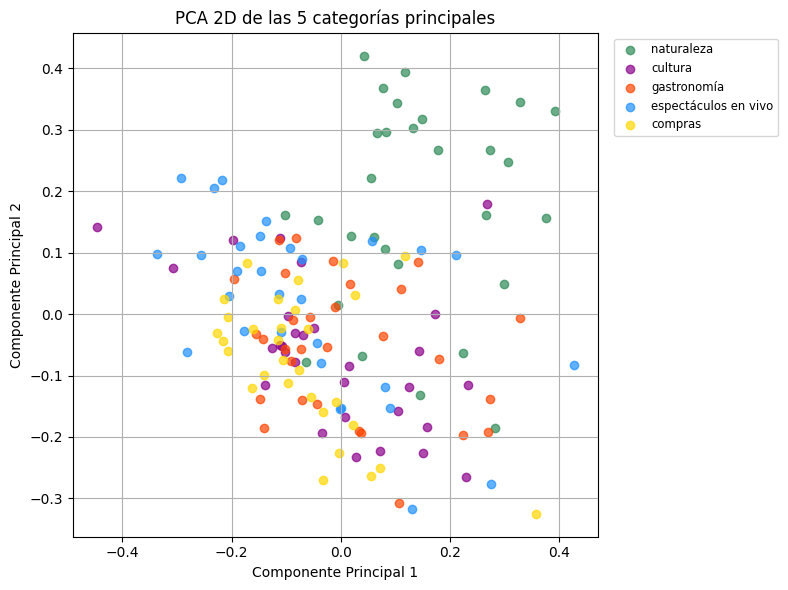

In [ ]:

root_classes = [
    "naturaleza",
    "cultura",
    "gastronomía",
    "espectáculos en vivo",
    "compras"
]
root_colors = {
    "naturaleza": "#2E8B57",
    "cultura":    "#8B008B",
    "gastronomía":"#FF4500",
    "espectáculos en vivo": "#1E90FF",
    "compras":    "#FFD700"
}

indices_root = [i for i, lab in enumerate(labels) if lab in root_classes]
X_root = X[indices_root, :].toarray()
labels_root = [labels[i] for i in indices_root]

pca_2d = PCA(n_components=2)
X_root_2d = pca_2d.fit_transform(X_root)

plt.figure(figsize=(8, 6))
for lab, color in root_colors.items():
    idx_lab = [i for i, l in enumerate(labels_root) if l == lab]
    plt.scatter(
        X_root_2d[idx_lab, 0],
        X_root_2d[idx_lab, 1],
        c=color,
        label=lab,
        alpha=0.7
    )

plt.title("PCA 2D de las 5 categorías principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()


En la visualización se aprecia que ciertas categorías como "naturaleza" están claramente separadas, es decir, que presentan patrones léxicos diferenciables.

Sin embargo, se ha identificado un leve solapamiento entre algunas clases en algunas regiones del espacio vectorial, en particular entre "gastronomía", "cultura" y "compras".

Este comportamiento es esperable, dado el uso de vocabulario compartido en contextos turísticos.

Aun así, una futura ampliación del corpus que incremente la variabilidad léxica en dichas clases podría mejorar la capacidad discriminativa del modelo.

### 2. d) Entrenamiento y evaluación de un modelo de regresión logística que prediga a qué nodo corresponde cada frase nueva.

Para el nodo raíz del árbol de decisión, se ha entrenado un modelo de regresión logística con aquellas frases del corpus que pertenecen a las cinco categorías principales: "naturaleza", "cultura", "gastronomía", "espectáculos en vivo" y "compras", pero que incluyen, tal y como se ha mencionado anteriormente, ejemplos de las subcategorías correspondientes.

A partir del conjunto de datos completo vectorizado, se ha extraído un subconjunto, `X_root, y_root` que incluye únicamente las instancias cuya etiqueta coincide con una clase del nivel 1 del árbol de decisión.

Este subconjunto se ha dividido en entrenamiento y prueba mediante `train_test_split`, con una partición estratificada del 80 % para entrenamiento y 20 % para prueba que asegura la representación balanceada de cada clase.

El modelo empleado ha sido una regresión logística `LogisticRegression` configurada con `max_iter=1000` para garantizar la convergencia durante el entrenamiento.

Tras el ajuste, se ha evaluado su rendimiento con las métricas estándar de clasificación (Precision, Recall y F1-score).


In [ ]:

root_classes = list(decision_tree["options"].keys())
indices_root = [i for i, lab in enumerate(labels) if lab in root_classes]

# Subconjunto de X y labels que usaremos en el nodo raíz
X_root = X[indices_root, :]
y_root = [labels[i] for i in indices_root]

Xtr_root, Xte_root, ytr_root, yte_root = train_test_split(
    X_root,
    y_root,
    test_size=0.20,
    stratify=y_root,
    random_state=42
)

clf_root = LogisticRegression(max_iter=1000)
clf_root.fit(Xtr_root, ytr_root)
y_pred_root = clf_root.predict(Xte_root)


print("\n Evaluación en el nodo raíz (5 clases):\n")
print(classification_report(yte_root, y_pred_root, digits=3))



 Evaluación en el nodo raíz (5 clases):

                      precision    recall  f1-score   support

             compras      1.000     0.667     0.800         6
             cultura      0.571     0.667     0.615         6
espectáculos en vivo      0.667     1.000     0.800         6
         gastronomía      1.000     0.667     0.800         6
          naturaleza      1.000     1.000     1.000         6

            accuracy                          0.800        30
           macro avg      0.848     0.800     0.803        30
        weighted avg      0.848     0.800     0.803        30



Los resultados evidencian que el modelo presenta un buen rendimiento con una precisión global del 80 % y una Macro-F1 de 0.803, resultado notable, si se tiene en cuenta el tamaño reducido del conjunto de prueba (30 instancias).

La clase “naturaleza” ha obtenido un rendimiento perfecto en todas las métricas (precisión, recall y F1-score = 1.000), hecho que confirma lo visualizado en 2D mediante PCA y que refleja que las instancias de esta categoría se hallan bien separadas en el espacio vectorial.

Por otro lado, la categoría “cultura” ha mostrado los valores más bajos, con un F1-score de 0.615.

Este resultado muestra cierto solapamiento léxico con otras clases, como “compras” o “gastronomía”, tal como se anticipaba en el análisis exploratorio.

Aun así, el recall del 0.667 en esta categoría indica que el modelo clasifica correctamente una parte significativa de los ejemplos, aunque confunde algunos con los de las clases vecinas.


### 2. e) Visualización 3D de las 5 categorías principales (PCA + RL)

Con el objetivo de localizar con precisión las frases de las categorías con mayor solapamiento, se ha procedido a la visualización 3D del clasificador, realizada sobre una versión reducida del espacio de datos mediante PCA, para identificar las fronteras de decisión establecidas por el modelo.

Sin embargo, esta representación no refleja fielmente el comportamiento del modelo real, entrenado en un espacio de mayor dimensión. Por tanto, debe entenderse como una herramienta ilustrativa, no como una evaluación exacta del modelo.

In [ ]:
# Filtrar las clases raíz
root_classes = ["naturaleza", "cultura", "gastronomía", "espectáculos en vivo", "compras"]
indices_root = [i for i, lab in enumerate(labels) if lab in root_classes]
X_root = X[indices_root, :].toarray()
labels_root = [labels[i] for i in indices_root]
texts_root = [corpus[i] for i in indices_root]

# Reducir dimensionalidad con PCA
pca_3d = PCA(n_components=3)
X_root_3d = pca_3d.fit_transform(X_root)

# Entrenar clasificador
clf_3d = LogisticRegression(max_iter=1000)
clf_3d.fit(X_root_3d, labels_root)

# Definir el grid para las predicciones del clasificador
x_min, x_max = X_root_3d[:, 0].min() - 0.5, X_root_3d[:, 0].max() + 0.5
y_min, y_max = X_root_3d[:, 1].min() - 0.5, X_root_3d[:, 1].max() + 0.5
z_min, z_max = X_root_3d[:, 2].min() - 0.5, X_root_3d[:, 2].max() + 0.5

grid_x = np.linspace(x_min, x_max, 20)
grid_y = np.linspace(y_min, y_max, 20)
grid_z = np.linspace(z_min, z_max, 20)
xx_3d, yy_3d, zz_3d = np.meshgrid(grid_x, grid_y, grid_z)
grid_points_3d = np.c_[xx_3d.ravel(), yy_3d.ravel(), zz_3d.ravel()]

# Predecir las clases del grid
Z_3d = clf_3d.predict(grid_points_3d)

# Codificar etiquetas numéricamente
label_mapping = {label: i for i, label in enumerate(root_classes)}
Z_numeric_3d = np.vectorize(label_mapping.get)(Z_3d)
Z_numeric_3d = Z_numeric_3d.reshape(xx_3d.shape)

# Colores para las clases raíz
root_colors = {
    "naturaleza": "#2E8B57",
    "cultura": "#8B008B",
    "gastronomía": "#FF4500",
    "espectáculos en vivo": "#1E90FF",
    "compras": "#FFD700"
}

# Crear la figura 3D
fig_3d = go.Figure()


# Añadir puntos clasificados
for lab in root_classes:
    idx_lab = [i for i, l in enumerate(labels_root) if l == lab]
    frases = np.array([texts_root[i] for i in idx_lab], dtype=object).reshape(-1, 1)
    fig_3d.add_trace(go.Scatter3d(
        x=X_root_3d[idx_lab, 0],
        y=X_root_3d[idx_lab, 1],
        z=X_root_3d[idx_lab, 2],
        mode='markers',
        marker=dict(size=6, color=root_colors[lab]),
        name=lab,
        customdata=frases,
        hovertemplate='<b>Categoría:</b> '+lab+'<br><b>Frase:</b> %{customdata[0]}<extra></extra>'
    ))


# Añadir superficie de decisión
fig_3d.add_trace(go.Isosurface(
    x=xx_3d.ravel(),
    y=yy_3d.ravel(),
    z=zz_3d.ravel(),
    value=Z_numeric_3d.ravel(),
    isomin=0,
    isomax=len(root_classes) - 1,
    surface_count=5,
    colorscale='Viridis',
    opacity=0.2,
    showscale=False,
    name='Fronteras de decisión'
))

# Configurar diseño del gráfico
fig_3d.update_layout(
    title="🌐 Visualización 3D de las 5 Categorías Principales (PCA + RL)",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    legend=dict(x=0, y=1)
)

# Mostrar gráfico
fig_3d.show()


 Cada punto representa una frase, coloreada según su categoría principal. Se observan agrupaciones razonablemente diferenciadas por clase, aunque con cierto solapamiento central entre “cultura”, “gastronomía” y “compras”, que indican similitudes léxicas entre algunas intenciones turísticas.

 Por ello, se procede mejorar la variabilidad de las categorías mencionadas a través de la ampliación del dataset de los cinco nodos principales.

### 2. f) Ampliación del dataset para las cinco categorías principales

Se añaden, mediante fusión de diccionarios, 40 frases por categoría principal, de modo que el dataset queda constituido por 70 frases en cada categoría principal, además de las 450 frases de las subcategorías correspondientes: 800 frases en total.

In [ ]:
new_examples_dict = {
    "naturaleza": [
        "Quiero desconectar en medio de la naturaleza y el mar",
        "Me apetece un bosque tranquilo junto a un río",
        "Prefiero perderme en rutas de montaña y respirar aire puro",
        "Deseo contemplar la puesta de sol en un acantilado natural",
        "Busco una experiencia rural con paisajes verdes",
        "Me interesa pasear por senderos naturales cerca del mar",
        "Quiero fotografiar la fauna en su entorno natural",
        "Me gustaría descansar bajo árboles centenarios",
        "Prefiero el sonido de los pájaros en un bosque frondoso",
        "Busco un lugar donde el paisaje sea el protagonista",
        "Me atraen los paseos por dunas y playas salvajes",
        "Quiero observar la naturaleza desde un mirador elevado",
        "Disfruto descubriendo cascadas escondidas",
        "Me interesa conocer los valles verdes de Cantabria",
        "Quiero pasar el día entre prados y bosques",
        "Me fascina la vida silvestre de las montañas cántabras",
        "Busco experiencias de ecoturismo y naturaleza virgen",
        "Quiero explorar cuevas y formaciones geológicas",
        "Me gustaría hacer picnic en un paraje natural",
        "Prefiero rutas en bicicleta por senderos naturales",
        "Quiero visitar jardines botánicos o arboretos",
        "Me encanta caminar junto a riachuelos en la montaña",
        "Busco zonas de baño natural en ríos o lagos",
        "Me atraen las reservas de la biosfera y espacios protegidos",
        "Quiero ver paisajes de alta montaña y nieve",
        "Me gustaría descubrir la naturaleza en pueblos remotos",
        "Prefiero estar rodeado de naturaleza sin ruidos urbanos",
        "Busco actividades al aire libre en espacios naturales",
        "Quiero conocer la flora autóctona de Cantabria",
        "Me interesa la observación de animales en libertad",
        "Disfruto de la tranquilidad en parques naturales",
        "Quiero recorrer senderos señalizados en entornos verdes",
        "Me atraen los paisajes de costa y acantilados naturales",
        "Quiero hacer una ruta de interpretación ambiental",
        "Me interesa la fotografía de paisajes naturales",
        "Prefiero el contacto directo con la naturaleza",
        "Quiero disfrutar de noches estrelladas lejos de la ciudad",
        "Busco rincones naturales de difícil acceso",
        "Quiero descubrir lugares poco conocidos de naturaleza",
        "Me fascina sentir la niebla y la humedad de los bosques"
        "Busco una playa virgen y natural con rocas"
    ],
    "cultura": [
        "Me gustaría asistir a una visita guiada por un casco antiguo",
        "Me gusta conocer el arte, la literatura del lugar",
        "Quiero descubrir los secretos de la historia local",
        "Me interesa conocer leyendas y mitos tradicionales",
        "Deseo asistir a una exposición de arte regional",
        "Quiero aprender sobre la arquitectura típica cántabra",
        "Me atraen los festivales y celebraciones tradicionales",
        "Busco rutas literarias y culturales por la ciudad",
        "Me gustaría participar en un taller de artesanía local",
        "Me interesa visitar monumentos emblemáticos de la región",
        "Prefiero un viaje con enfoque cultural e histórico",
        "Quiero recorrer iglesias y ermitas antiguas",
        "Busco información sobre la cultura popular de Cantabria",
        "Me interesa el arte contemporáneo y las galerías locales",
        "Deseo sumergirme en la música tradicional cántabra",
        "Quiero conocer los símbolos culturales del lugar",
        "Prefiero experiencias inmersivas en tradiciones vivas",
        "Me atrae la danza y el folclore local",
        "Quiero explorar bibliotecas y centros culturales",
        "Me gustaría ver una reconstrucción histórica",
        "Busco eventos culturales únicos de la zona",
        "Me interesa la arqueología y los restos prehistóricos",
        "Quiero admirar los retablos y esculturas antiguas",
        "Me gusta conocer la evolución histórica de los pueblos",
        "Quiero visitar archivos y museos etnográficos",
        "Me interesa la vida y obra de personajes célebres locales",
        "Busco experiencias didácticas sobre el pasado",
        "Prefiero recorridos culturales a visitas comerciales",
        "Quiero asistir a conferencias o charlas históricas",
        "Me atraen los mercados de antigüedades y arte",
        "Quiero pasear por palacios y mansiones históricas",
        "Me gustaría aprender sobre la gastronomía tradicional y su historia",
        "Deseo ver reconstrucciones de oficios antiguos",
        "Busco rutas por espacios declarados Patrimonio de la Humanidad",
        "Me interesa la literatura cántabra y sus autores",
        "Quiero explorar la huella romana en la región",
        "Me atrae la mezcla de estilos arquitectónicos históricos",
        "Prefiero actividades de aprendizaje cultural",
        "Me gustaría visitar centros de interpretación cultural",
        "Quiero empaparme de la cultura local en todas sus formas"
    ],
    "gastronomía": [
        "Quiero degustar pinchos y tapas tradicionales",
        "Me interesa una ruta gastronómica por diferentes pueblos",
        "Unas rabas, sueño con ellas",
        "Beber orujo de Liébana con cocido montñés",
        "Deseo probar mariscos recién capturados en la costa",
        "Quiero asistir a una feria de productos locales",
        "Me gustaría hacer una cata de quesos artesanos",
        "Busco restaurantes con estrella Michelin o cocina de autor",
        "Quiero probar postres típicos y repostería cántabra",
        "Prefiero descubrir recetas antiguas de la región",
        "Me interesa la cocina marinera de Cantabria",
        "Quiero aprender a cocinar un plato típico cántabro",
        "Me gustaría cenar en una taberna con encanto",
        "Deseo saborear sidra y cervezas artesanas locales",
        "Quiero descubrir rutas de tapas y bares tradicionales",
        "Me atrae la cocina de montaña y sus guisos",
        "Prefiero los menús degustación con productos autóctonos",
        "Busco experiencias gastronómicas en entornos rurales",
        "Quiero probar pescado fresco en puerto pesquero",
        "Me gustaría hacer picnic con productos del mercado",
        "Deseo un tour por granjas y productores locales",
        "Quiero conocer la historia de los platos tradicionales",
        "Me atraen las jornadas de degustación temática",
        "Prefiero cenas maridadas con vinos de la zona",
        "Busco probar nuevas tendencias de cocina cántabra",
        "Me gustaría hacer una cata de aceites y mieles",
        "Quiero descubrir la cocina vegetariana local",
        "Me interesa la cocina sostenible y de kilómetro cero",
        "Deseo comprar productos gourmet de la región",
        "Quiero experimentar la cocina fusión con ingredientes locales",
        "Prefiero una escapada culinaria en pareja",
        "Me atraen las terrazas con vistas para comer",
        "Quiero conocer a chefs locales y sus creaciones",
        "Me gustaría asistir a un taller de repostería cántabra",
        "Busco restaurantes con menú del día típico regional",
        "Quiero probar diferentes variedades de pan artesanal",
        "Deseo una experiencia gastronómica en el campo",
        "Me interesa la cerveza local y sus variedades",
        "Prefiero los guisos de cuchara tradicionales",
        "Quiero descubrir productos ecológicos de Cantabria"
    ],
    "espectáculos en vivo": [
        "Quiero asistir a un festival de música al aire libre",
        "Quiero conocer a un escritor en un encuentro literario",
        "Quiero disfrutar de conciertos en bares pequeños",
        "Me interesa la programación de ópera en Cantabria",
        "Deseo vivir la experiencia de un musical en directo",
        "Prefiero espectáculos de magia y humor",
        "Quiero ir a ver una función de circo moderno",
        "Me atraen los recitales de poesía en vivo",
        "Busco eventos con artistas emergentes",
        "Quiero asistir a proyecciones de cine al aire libre",
        "Me interesa el flamenco y la música tradicional en escena",
        "Prefiero espectáculos familiares o infantiles",
        "Quiero descubrir festivales de teatro alternativo",
        "Me gustaría bailar en conciertos de música folk",
        "Busco una noche de jazz en directo",
        "Quiero ver representaciones de marionetas o títeres",
        "Me interesa la improvisación teatral",
        "Prefiero eventos de narración oral en vivo",
        "Quiero asistir a concursos o galas culturales",
        "Me gustaría ver desfiles o espectáculos de moda",
        "Busco actividades escénicas en la calle",
        "Quiero disfrutar de teatro clásico en verano",
        "Me atraen los festivales multidisciplinares",
        "Deseo ver artistas internacionales en directo",
        "Quiero participar en jams musicales",
        "Me interesa la agenda de conciertos de la ciudad",
        "Prefiero una noche de stand-up comedy",
        "Busco eventos con interacción del público",
        "Quiero disfrutar de la magia del directo",
        "Me gustaría asistir a galas benéficas",
        "Quiero ver shows de talento local",
        "Busco un evento con ambiente festivo y cultural",
        "Prefiero asistir a una zarzuela o revista musical",
        "Quiero disfrutar de espectáculos al atardecer",
        "Me interesa el arte escénico experimental",
        "Quiero asistir a un espectáculo de luces y sonido",
        "Me gustaría vivir un estreno teatral",
        "Prefiero las actuaciones al aire libre en verano",
        "Quiero sorprenderme con espectáculos originales",
        "Sueño con un concierto en vivo",
    ],
    "compras": [
        "Quiero visitar mercados tradicionales de la región",
        "Me interesa comprar moda local de diseñadores cántabros",
        "Busco tiendas de segunda mano o vintage",
        "Quiero adquirir productos ecológicos y artesanales",
        "Prefiero comprar en mercadillos al aire libre",
        "Quiero encontrar regalos originales y diferentes",
        "Me gustaría recorrer galerías de arte con obras a la venta",
        "Busco ropa con sello cántabro",
        "Quiero productos de cosmética natural local",
        "Me interesa la joyería artesanal cántabra",
        "Prefiero tiendas que apuestan por el diseño local",
        "Quiero comprar objetos de decoración típicos",
        "Busco outlets de productos regionales",
        "Me gustaría visitar una feria de artesanía",
        "Quiero adquirir productos gourmet como souvenir",
        "Me interesa la moda sostenible hecha en Cantabria",
        "Prefiero apoyar el comercio local y de proximidad",
        "Quiero comprar recuerdos hechos a mano",
        "Busco libros y material cultural cántabro",
        "Me gustaría adquirir cerámica y piezas únicas",
        "Quiero descubrir tiendas con historia",
        "Me atraen los mercados navideños y de temporada",
        "Prefiero comprar alimentos típicos en tiendas especializadas",
        "Quiero sorprender con un regalo de diseño cántabro",
        "Me interesa la bisutería hecha en Cantabria",
        "Quiero llevarme productos personalizados",
        "Busco complementos exclusivos de la región",
        "Me gustaría comprar souvenirs originales y auténticos",
        "Quiero adquirir textiles y mantas locales",
        "Prefiero objetos de arte y diseño únicos",
        "Quiero conocer tiendas gourmet de productos autóctonos",
        "Busco detalles únicos para ocasiones especiales",
        "Me interesa la papelería creativa local",
        "Prefiero tiendas de regalos modernos y alternativos",
        "Quiero comprar instrumentos musicales cántabros",
        "Busco productos típicos en cooperativas locales",
        "Me gustaría hacer compras en una feria de productores",
        "Quiero encontrar piezas de mobiliario artesano",
        "Me interesa la moda urbana con identidad local",
        "Quiero algo moderno de recuerdo",
    ]
}


In [ ]:
# Fusionar new_examples_dict con examples_dict sin duplicados
for categoria, nuevas_frases in new_examples_dict.items():
    if categoria in examples_dict:
        examples_dict[categoria].extend([
            frase for frase in nuevas_frases if frase not in examples_dict[categoria]
        ])
    else:
        examples_dict[categoria] = list(nuevas_frases)
for categoria, frases in examples_dict.items():
    print(f"{categoria}: {len(frases)} frases")

naturaleza: 70 frases
cultura: 70 frases
gastronomía: 70 frases
espectáculos en vivo: 70 frases
compras: 70 frases
montaña: 30 frases
costa: 30 frases
parques naturales: 30 frases
historia: 30 frases
arte: 30 frases
tradiciones vivas: 30 frases
carne: 30 frases
mariscos: 30 frases
dulces típicos: 30 frases
música: 30 frases
teatro: 30 frases
encuentros literarios: 30 frases
tradicionales: 30 frases
modernos: 30 frases
souvenirs: 30 frases


### 2. g) Reentrenamiento del modelo de regresión logística

Se procede a continuación (previa vectorización sobre el conjunto de todos los datos) a reentrenar el modelo de regresión logística sobre las cinco categorías principales, con el dataset ampliado para mejorar su rendimiento.

In [ ]:

corpus = []
labels = []
for label, examples in examples_dict.items():
    corpus.extend(examples)
    labels.extend([label] * len(examples))

vectorizer = TfidfVectorizer(lowercase=True, strip_accents="unicode")
X = vectorizer.fit_transform(corpus)
print(X.shape)


(800, 1099)


In [ ]:

root_classes = list(decision_tree["options"].keys())
indices_root = [i for i, lab in enumerate(labels) if lab in root_classes]

# Subconjunto de X y labels que usaremos en el nodo raíz
X_root = X[indices_root, :]
y_root = [labels[i] for i in indices_root]

Xtr_root, Xte_root, ytr_root, yte_root = train_test_split(
    X_root,
    y_root,
    test_size=0.20,
    stratify=y_root,
    random_state=42
)

clf_root = LogisticRegression(max_iter=1000)
clf_root.fit(Xtr_root, ytr_root)
y_pred_root = clf_root.predict(Xte_root)


print("\n Evaluación en el nodo raíz (5 clases):\n")
print(classification_report(yte_root, y_pred_root, digits=3))



 Evaluación en el nodo raíz (5 clases):

                      precision    recall  f1-score   support

             compras      1.000     0.929     0.963        14
             cultura      0.706     0.857     0.774        14
espectáculos en vivo      0.909     0.714     0.800        14
         gastronomía      0.667     0.857     0.750        14
          naturaleza      0.909     0.714     0.800        14

            accuracy                          0.814        70
           macro avg      0.838     0.814     0.817        70
        weighted avg      0.838     0.814     0.817        70





   **Comparativa del rendimiento del modelo según el dataset empleado**

| Métrica               | Dataset Ampliado (70 ejemplos) | Dataset Reducido (30 ejemplos) |
|-----------------------|-------------------------------|---------------------------------|
| **Accuracy**          | 0.814                         | 0.800                           |
| **Macro F1-score**    | 0.817                         | 0.803                           |
| **Weighted F1-score** | 0.817                         | 0.803                           |
| **Mejor clase (F1)**  | Compras (0.963)               | Naturaleza (1.000)              |
| **Peor clase (F1)**   | Gastronomía (0.750)           | Cultura (0.615)                 |
| **Precision media**   | 0.838                         | 0.848                           |
| **Recall medio**      | 0.814                         | 0.800                           |
| **Consistencia**      | Alta, buen balance entre clases | Baja, mayor variabilidad       |




El empleo del dataset ampliado ha mejorado la calidad del clasificador raíz. Se observa una mejor distribución del rendimiento entre clases y un mejor F1-macro: 0.817.

Además, el reentrenamiento con el dataset ampliado ha mejorado la separabilidad de las clases con mayor solapamiento léxico como "cultura" o "gastronomía".


### 2. h) Implementación inicial de CanBot: navegación jerárquica y clasificación dinámica por nodos con modelos de regresión logística

Para la fase inicial de implementación del chatbot CanBot, se ha desarrollado un flujo conversacional basado en la estructura jerárquica del árbol de decisiones.

CanBot guía al usuario a través de una serie de preguntas dinámicas, según sus preferencias, hasta llegar a una recomendación personalizada.

En el primer nivel, se utiliza el modelo de regresión logística previamente entrenado y evaluado con el dataset ampliado para las cinco categorías principales, basado en representaciones TF-IDF del corpus completo. (El sistema permite, además, una ampliación sencilla con el añadido de frases a `examples_dict.`)

En los niveles siguientes, el sistema aplica la clasificación jerárquica mediante el entrenamiento de modelos específicos en tiempo real con los ejemplos asociados a cada subcategoría del árbol.

De este modo, el sistema presenta una arquitectura modular con funciones desacopladas: `run_chatbot_ml` que gestiona el flujo conversacional y `ml_classify `, que se encarga de la clasificación de intenciones.

Esta separación permite modificar o mejorar los modelos de clasificación sin afectar la lógica de interacción,  ya que la estructura recursiva de `run_chatbot_ml` aplica el mismo esquema modular en cada nivel del árbol de decisiones.

De esta manera, se consigue una estructura del flujo modular y coherente con la organización jerárquica del árbol de decisión.

In [ ]:

# --- Función de clasificación ---
def ml_classify(options, user_input, examples_dict, preloaded_model=None, preloaded_vectorizer=None):
    if preloaded_model is not None and preloaded_vectorizer is not None:
        X_input = preloaded_vectorizer.transform([user_input])
        prediction = preloaded_model.predict(X_input)[0]
        return prediction

    training_texts = []
    training_labels = []
    for option in options:
        examples = examples_dict.get(option, [option])
        training_texts.extend(examples)
        training_labels.extend([option] * len(examples))

    vectorizer = TfidfVectorizer(lowercase=True, strip_accents="unicode")
    X_train = vectorizer.fit_transform(training_texts)
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, training_labels)
    X_input = vectorizer.transform([user_input])
    prediction = classifier.predict(X_input)[0]
    return prediction

# --- Flujo del chatbot ---
def run_chatbot_ml(node, examples_dict, model=None, vectorizer=None):
    if isinstance(node, str):
        # Mejora final: transformar "recomienda:" en una frase natural
        if node.lower().startswith("recomienda:"):
            print("\n✅ Te recomiendo" + node[len("recomienda:"):])
        else:
            print("\n✅", node)
        return

    options = node.get("options", {})
    opciones_str = " / ".join(options.keys())
    user_input = input(f"{node['question']} ({opciones_str}): ").strip().lower()

    predicted_option = ml_classify(
        options,
        user_input,
        examples_dict,
        preloaded_model=model,
        preloaded_vectorizer=vectorizer
    )

    # Comentado: salida técnica solo para pruebas
    # print(f"👉 Opción interpretada: {predicted_option}")

    if predicted_option in options:
        run_chatbot_ml(options[predicted_option], examples_dict)
    else:
        print("❌ No se pudo interpretar tu intención. Inténtalo con otra frase.")

# --- Lanzamiento del chatbot ---
print("\n🗺️ Hola, soy Canbot, tu guía turístico por Cantabria 🏞️\n")
run_chatbot_ml(decision_tree, examples_dict, model=clf_root, vectorizer=vectorizer)



🗺️ Hola, soy Canbot, tu guía turístico por Cantabria 🏞️

¿Qué tipo de experiencia te gustaría vivir en Cantabria? (naturaleza / cultura / gastronomía / espectáculos en vivo / compras): relajarme en el mar
¿Prefieres montaña, costa o parques naturales? (montaña / costa / parques naturales): la playa

✅ Te recomiendo Surf en Somo con tabla alquilada



 ## Fase 3: Incorporación de Redes Neuronales para clasificar intenciones complejas



 ### 3. a) Entrenamiento de una pequeña red neuronal de 2 capas y 20 neuronas

Con el objetivo de analizar la viabilidad de incorporar otras técnicas a nuestro sistema CantBot, en esta fase, tras importarse las librerías y módulos necesarios, se han entrenado dos modelos de redes neuronales: el primero emplea como entrada representaciones vectoriales basadas en TF-IDF y el segundo embeddings semánticos dinámicos para capturar relaciones contextuales entre palabras.

Ambos modelos se han evaluado y comparado con el clasificador de regresión logística desarrollado anteriormente, con la finalidad de seleccionar la arquitectura más adecuada para la clasificación de intenciones generales en los nodos principales del árbol de decisión.


In [ ]:
!pip install numpy scikit-learn matplotlib tensorflow keras pandas seaborn

In [ ]:
# --- Manipulación de datos ---
import pandas as pd

# --- Visualización ---
import seaborn as sns

# --- Evaluación (complemento) ---
from sklearn.metrics import confusion_matrix, accuracy_score

# --- Red neuronal (Keras / TensorFlow) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Utilidades ---
import time


 #### 3. a) 1.  Preparación de datos para el modelo basado en TF-IDF

Para entrenar y evaluar la red neuronal basada en representaciones TF-IDF, se ha seleccionado el subconjunto ampliado del dataset correspondiente a las cinco categorías raíz del árbol de decisión: "naturaleza", "cultura", "gastronomía", "espectáculos en vivo" y "compras".

De este modo, se han extraído las frases asociadas a estas clases junto con sus etiquetas y se han vectorizado mediante la técnica TF-IDF (Term Frequency - Inverse Document Frequency), ya empleada en el modelo de regresión logística.

Se ha utilizado el mismo vectorizador entrenado sobre el corpus completo para garantizar coherencia en el espacio de representación textual.

Las etiquetas asociadas a las frases se han codificado en formato one-hot, necesario para emplear la función de pérdida categórica cruzada y una capa de salida con activación softmax en el modelo neuronal.

Posteriormente, los datos han sido divididos en conjunto de entrenamiento (80 %) y prueba (20 %), en proporción a las clases correspondientes.

Por último, se ha mostrado un ejemplo concreto del preprocesamiento aplicado, incluyendo el análisis de las palabras más representativas en el vector TF-IDF de una frase específica.

In [ ]:
root_classes = ["naturaleza", "cultura", "gastronomía", "espectáculos en vivo", "compras"]

texts_root, labels_root = [], []
for subcat, frases in examples_dict.items():
    if subcat in root_classes:
        texts_root.extend(frases)
        labels_root.extend([subcat] * len(frases))

for categoria in sorted(root_classes):
    count = labels_root.count(categoria)
    print(f"  - {categoria}: {count} ejemplos ({count/len(labels_root)*100:.1f}%)")

X_root = vectorizer.transform(texts_root).toarray()

print(f"\nMatriz TF-IDF (5 raíces): {X_root.shape} (ejemplos × características)")
feature_names = vectorizer.get_feature_names_out()
print("Algunas palabras clave en el vocabulario (5 raíces):")
print(", ".join(feature_names[:10]))

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder_root = LabelEncoder()
integer_encoded_root = label_encoder_root.fit_transform(labels_root)
onehot_encoder_root = OneHotEncoder(sparse_output=False)
y_root = onehot_encoder_root.fit_transform(integer_encoded_root.reshape(-1, 1))

print(f"\nMatriz de etiquetas one-hot (5 raíces): {y_root.shape} (ejemplos × 5)")
print(f"Categorías codificadas: {label_encoder_root.classes_}")

from sklearn.model_selection import train_test_split
X_train_root, X_test_root, y_train_root, y_test_root = train_test_split(
    X_root, y_root, test_size=0.2, stratify=y_root, random_state=42
)

print("\nDatos divididos (5 raíces):")
print(f"  - Entrenamiento: {X_train_root.shape[0]} ejemplos")
print(f"  - Prueba:         {X_test_root.shape[0]} ejemplos")

ejemplo_idx = 5
ejemplo_texto = texts_root[ejemplo_idx]
ejemplo_categoria = labels_root[ejemplo_idx]
ejemplo_vector = X_root[ejemplo_idx]

print(f"\nEjemplo de dato procesado (5 raíces):")
print(f"  - Texto original: '{ejemplo_texto}'")
print(f"  - Categoría raíz: {ejemplo_categoria}")
print(f"  - Vector TF-IDF: {ejemplo_vector.shape} (mostrando los 5 valores más altos)")

indices_importantes = np.argsort(ejemplo_vector)[-5:][::-1]
for idx in indices_importantes:
    if ejemplo_vector[idx] > 0:
        print(f"    '{feature_names[idx]}': {ejemplo_vector[idx]:.4f}")


  - compras: 70 ejemplos (20.0%)
  - cultura: 70 ejemplos (20.0%)
  - espectáculos en vivo: 70 ejemplos (20.0%)
  - gastronomía: 70 ejemplos (20.0%)
  - naturaleza: 70 ejemplos (20.0%)

Matriz TF-IDF (5 raíces): (350, 1099) (ejemplos × características)
Algunas palabras clave en el vocabulario (5 raíces):
abiertos, acabados, acantilado, acantilados, accesible, accesibles, acceso, aceites, acompanar, actividad

Matriz de etiquetas one-hot (5 raíces): (350, 5) (ejemplos × 5)
Categorías codificadas: ['compras' 'cultura' 'espectáculos en vivo' 'gastronomía' 'naturaleza']

Datos divididos (5 raíces):
  - Entrenamiento: 280 ejemplos
  - Prueba:         70 ejemplos

Ejemplo de dato procesado (5 raíces):
  - Texto original: 'Me encanta caminar por playas tranquilas en entornos naturales'
  - Categoría raíz: naturaleza
  - Vector TF-IDF: (1099,) (mostrando los 5 valores más altos)
    'tranquilas': 0.4759
    'entornos': 0.4012
    'playas': 0.4012
    'caminar': 0.3485
    'naturales': 0.3344


 #### 3. a) 2.  Análisis visual del espacio vectorial con el nuevo dataset mediante PCA

Antes de entrenar la red neuronal, se ha realizado un nuevo análisis exploratorio del espacio de entrada (las frases del dataset de las cinco categorías radicales) mediante PCA (Análisis de Componentes Principales), de modo que los vectores TF-IDF se han proyectado en un espacio tridimensional.

A pesar de que anteriormente ya se había realizado una visualización de estos datos con el mismo vectorizador, en esta ocasión el análisis se ha realizado sobre el corpus ampliado.

Además, se han calculado las distancias entre centroides, así como la varianza explicada por cada componente con el objeto de identificar las clases con baja dispersión interna.

PCA (5 raíces) - Varianza explicada:
  - Componente 1: 2.17%
  - Componente 2: 1.66%
  - Componente 3: 1.59%
Suma varianza explicada: 5.43%

⚠️ Varianza explicada < 70%: Estructura compleja en más dimensiones.



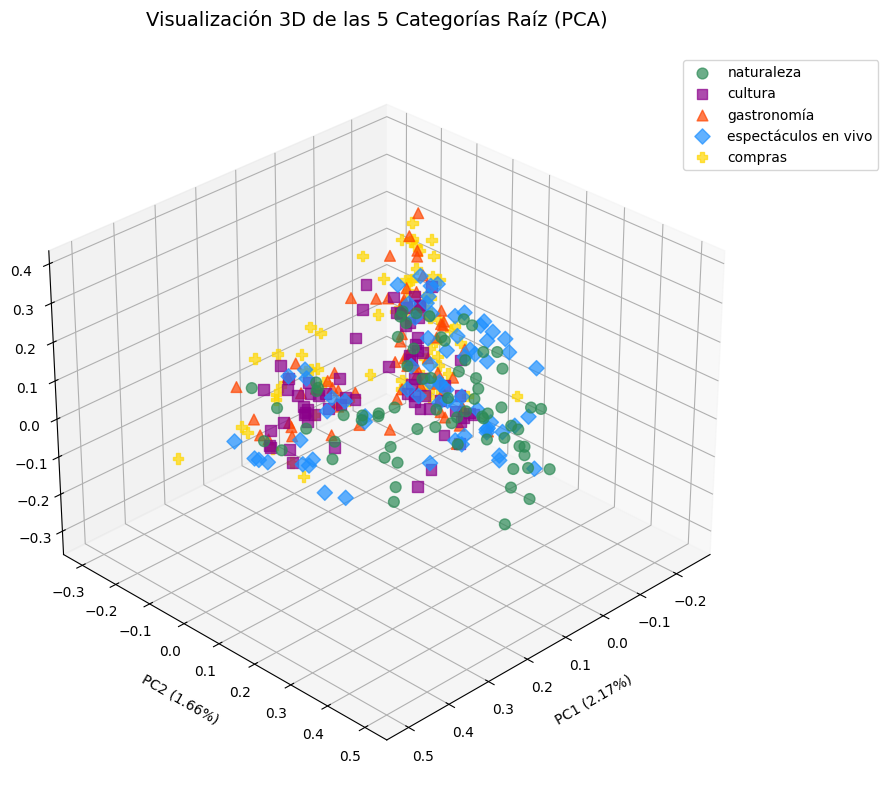

<Figure size 1200x1000 with 0 Axes>

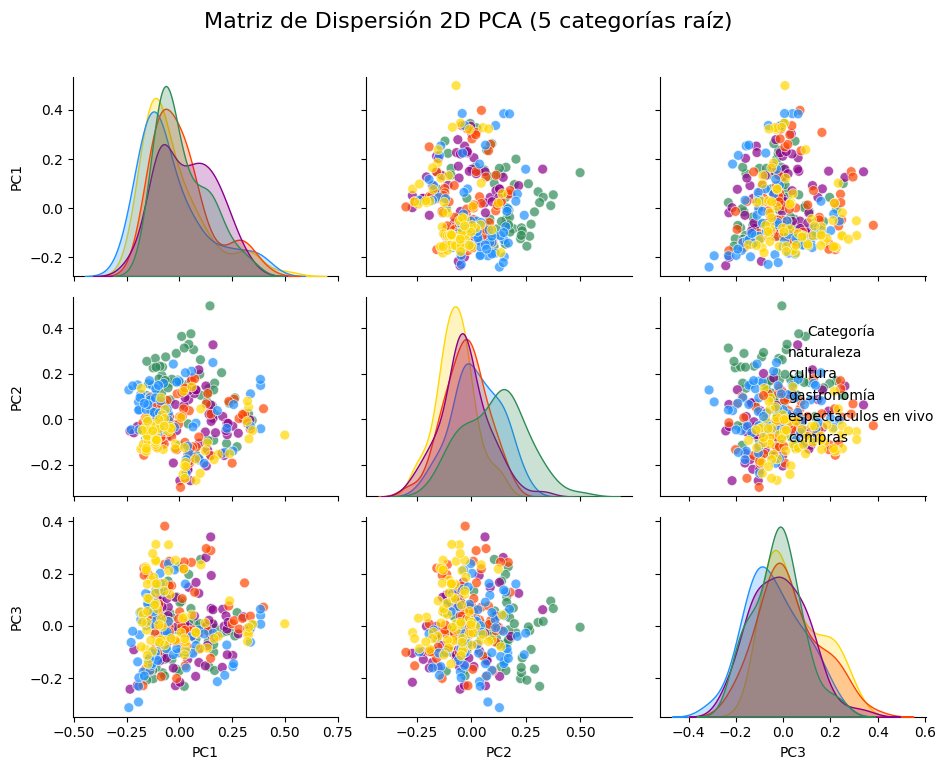

Análisis de la estructura visual (5 raíces):
  Datos muy no lineales; clasificador lineal tendrá dificultad.

Pares con menor separación (5 raíces):
  - cultura y gastronomía: distancia = 0.0502
  - gastronomía y compras: distancia = 0.0585
  - cultura y espectáculos en vivo: distancia = 0.0902


In [ ]:
pca = PCA(n_components=3)
X_root_pca = pca.fit_transform(X_root)

explained_variance = pca.explained_variance_ratio_ * 100
print("PCA (5 raíces) - Varianza explicada:")
for i, var in enumerate(explained_variance):
    print(f"  - Componente {i+1}: {var:.2f}%")
print(f"Suma varianza explicada: {explained_variance.sum():.2f}%\n")

if explained_variance.sum() < 70:
    print("⚠️ Varianza explicada < 70%: Estructura compleja en más dimensiones.\n")

df_root_pca = pd.DataFrame(X_root_pca, columns=['PC1', 'PC2', 'PC3'])
df_root_pca['Categoría'] = labels_root


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {
    "naturaleza": "#2E8B57",
    "cultura":    "#8B008B",
    "gastronomía":"#FF4500",
    "espectáculos en vivo": "#1E90FF",
    "compras":    "#FFD700"
}
markers = {'naturaleza':'o','cultura':'s','gastronomía':'^','espectáculos en vivo':'D','compras':'P'}

for cat, col in colors.items():
    idx = df_root_pca['Categoría'] == cat
    ax.scatter(
        df_root_pca.loc[idx, 'PC1'],
        df_root_pca.loc[idx, 'PC2'],
        df_root_pca.loc[idx, 'PC3'],
        c=col, marker=markers[cat], s=60, alpha=0.7, label=cat
    )

ax.set_title('Visualización 3D de las 5 Categorías Raíz (PCA)', fontsize=14, pad=20)
ax.set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({explained_variance[1]:.2f}%)', labelpad=10)
ax.set_zlabel(f'PC3 ({explained_variance[2]:.2f}%)', labelpad=10)
ax.grid(True)
ax.view_init(elev=30, azim=45)
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.pairplot(df_root_pca, hue='Categoría', palette=list(colors.values()), height=2.5,
             plot_kws={'alpha':0.7, 's': 50, 'edgecolor': 'w'})
plt.suptitle('Matriz de Dispersión 2D PCA (5 categorías raíz)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Análisis de la estructura visual (5 raíces):")
if explained_variance.sum() < 50:
    print("  Datos muy no lineales; clasificador lineal tendrá dificultad.")
elif explained_variance[:2].sum() > 70:
    print("  Las dos primeras componentes explican > 70% de varianza; buena separabilidad lineal.")
else:
    print("  Estructura compleja: algunas categorías se solapan, otras se separan bien.")

centroid_distances = []
for i, cat1 in enumerate(root_classes):
    for j, cat2 in enumerate(root_classes):
        if i < j:
            c1 = df_root_pca[df_root_pca['Categoría'] == cat1][['PC1','PC2','PC3']].mean().values
            c2 = df_root_pca[df_root_pca['Categoría'] == cat2][['PC1','PC2','PC3']].mean().values
            dist = np.linalg.norm(c1 - c2)
            centroid_distances.append((cat1, cat2, dist))

centroid_distances.sort(key=lambda x: x[2])
print("\nPares con menor separación (5 raíces):")
for cat1, cat2, d in centroid_distances[:3]:
    print(f"  - {cat1} y {cat2}: distancia = {d:.4f}")


El análisis ha revelado que las tres primeras componentes principales explican conjuntamente solo el 5.43% de la varianza total del conjunto vectorizado mediante TF-IDF. Este valor, muy por debajo del umbral del 70%, confirma que la información relevante para la clasificación se encuentra distribuida en un espacio de alta dimensionalidad (874 dimensiones), que complica la proyección visual y la separación lineal entre clases.

Esta complejidad estructural se corrobora en la visualización 3D y en la matriz de dispersión 2D por pares de componentes principales,en la que se observa un alto grado de solapamiento entre categorías, especialmente entre las componentes PC1 y PC3.

Por otro lado, los histogramas y curvas de densidad muestran que la categoría “naturaleza” presenta una distribución más diferenciada respecto a las demás, hecho que coincide con su mejor rendimiento en el modelo de regresión logística.

Adicionalmente, se han calculado las distancias euclídeas entre centroides de cada clase en el espacio PCA reducido. Los pares de categorías con menor separación han sido:

"cultura y gastronomía": 0.0502

"gastronomía y compras": 0.0585

"cultura y espectáculos en vivo": 0.0902

Estos resultados refuerzan la idea de que ciertas clases comparten un vocabulario semántico próximo, que puede inducir errores en clasificadores lineales como la regresión logística.

Por ello, se justifica la exploración de redes neuronales como alternativa para mejorar la separación categorial mediante las transformaciones espaciales de las funciones de activación.

 #### 3. a) 3. Entrenamiento: red neuronal sencilla: dos 2 capas, 10-20 neuronas



Tras la preparación del conjunto de datos correspondiente a las cinco categorías raíz del árbol de decisión, se ha entrenado una red neuronal con una arquitectura secuencial sencilla: dos capas ocultas con 20 y 10 neuronas respectivamente con funciones de activación ReLU (Rectified Linear Unit), seguidas de una capa de salida con activación `softmax `para clasificación multiclase.

El modelo se ha compilado utilizando el optimizador Adam y la función de pérdida `categorical_crossentropy,` adecuada para problemas con etiquetas codificadas en formato one-hot.

El entrenamiento se ha realizado durante un máximo de 100 épocas, con un mecanismo de `early stopping` para evitar sobreajuste y detener el entrenamiento, en caso de que no mejore la función de pérdida del conjunto de validación.


Entrenando la red neuronal (capas 20-10)...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1848 - loss: 1.6107 - val_accuracy: 0.2143 - val_loss: 1.6072
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3316 - loss: 1.5960 - val_accuracy: 0.2143 - val_loss: 1.6036
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4139 - loss: 1.5835 - val_accuracy: 0.2143 - val_loss: 1.5983
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4487 - loss: 1.5677 - val_accuracy: 0.2679 - val_loss: 1.5907
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5129 - loss: 1.5463 - val_accuracy: 0.3214 - val_loss: 1.5798
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5367 - loss: 1.5176 - val_accuracy: 0.3750 - val_loss: 1.5651
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5808 - loss: 1.4785 - val_accuracy: 0.4107 - val_loss: 1.5454
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6487 - loss: 1.4286 - val_accuracy: 0.4286 - val_loss: 1

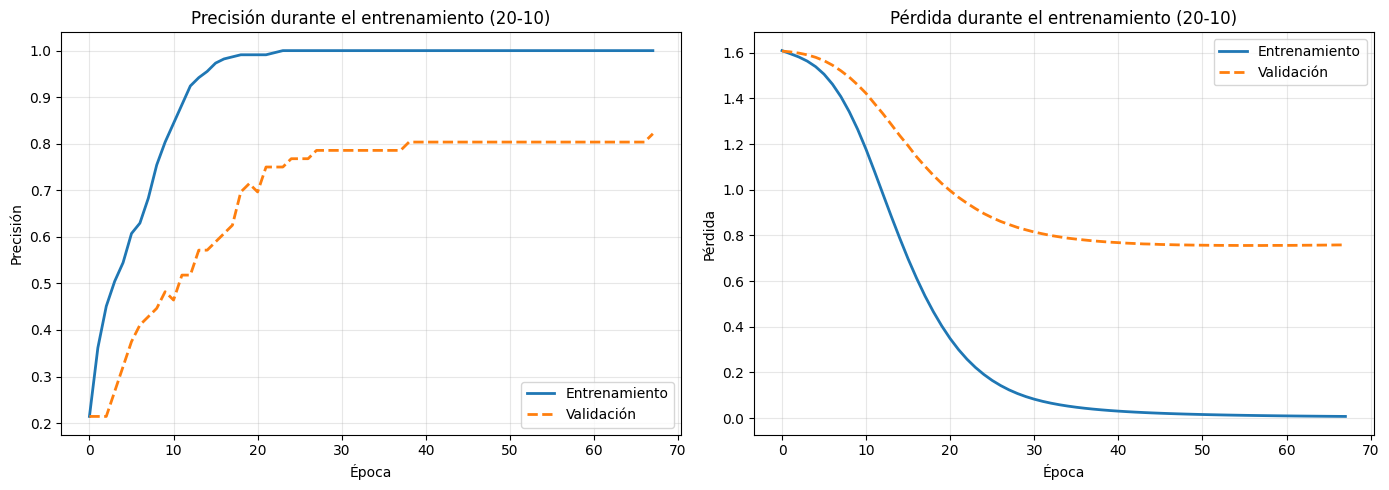

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

 Métricas generales (macro):
  - F1-score:     0.6819
  - Precisión:    0.6972
  - Recall:       0.6857
  - Accuracy:     0.6857

📋Reporte por clase:
                      precision    recall  f1-score   support

             compras      0.550     0.786     0.647        14
             cultura      0.667     0.429     0.522        14
espectáculos en vivo      0.769     0.714     0.741        14
         gastronomía      0.714     0.714     0.714        14
          naturaleza      0.786     0.786     0.786        14

            accuracy                          0.686        70
           macro avg      0.697     0.686     0.682        70
        weighted avg      0.697     0.686     0.682        70



In [ ]:
# --- Semilla para reproducibilidad ---
import random, numpy as np, tensorflow as tf, os
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# --- Modelo y entrenamiento ---
model_root = Sequential([
    Dense(20, activation='relu', input_shape=(X_train_root.shape[1],), kernel_initializer='he_normal', name='hidden1'),
    Dense(10, activation='relu', kernel_initializer='he_normal', name='hidden2'),
    Dense(y_train_root.shape[1], activation='softmax', name='output')
])
model_root.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

start_time = time.time()
print("\nEntrenando la red neuronal (capas 20-10)")
history_root = model_root.fit(
    X_train_root, y_train_root,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
training_time = time.time() - start_time
print(f"\n⏱ Tiempo de entrenamiento: {training_time:.2f} segundos")

loss_root, acc_root = model_root.evaluate(X_test_root, y_test_root, verbose=0)
print(f"\n Evaluación en test (capas 20-10):")
print(f"  - Pérdida: {loss_root:.4f}")
print(f"  - Precisión: {acc_root:.4f} ({acc_root*100:.2f}%)")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_root.history['accuracy'], label='Entrenamiento', linewidth=2)
plt.plot(history_root.history['val_accuracy'], label='Validación', linestyle='--', linewidth=2)
plt.title('Precisión durante el entrenamiento (20-10)')
plt.xlabel('Época'); plt.ylabel('Precisión')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_root.history['loss'], label='Entrenamiento', linewidth=2)
plt.plot(history_root.history['val_loss'], label='Validación', linestyle='--', linewidth=2)
plt.title('Pérdida durante el entrenamiento (20-10)')
plt.xlabel('Época'); plt.ylabel('Pérdida')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Métricas adicionales ---
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

y_pred_probs = model_root.predict(X_test_root)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_root, axis=1)

f1 = f1_score(y_true_labels, y_pred_labels, average='macro')
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("\n Métricas generales (macro):")
print(f"  - F1-score:     {f1:.4f}")
print(f"  - Precisión:    {precision:.4f}")
print(f"  - Recall:       {recall:.4f}")
print(f"  - Accuracy:     {accuracy:.4f}")

print("\n📋Reporte por clase:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder_root.classes_, digits=3))


Tras entrenar la red neuronal simple sobre el mismo conjunto vectorizado mediante TF-IDF que la regresión logística, se ha observado que el rendimiento final es inferior en el conjunto de prueba al del modelo de Aprendizaje Automático (exactitud del 68.57 % y un macro-F1 de 0.6819).

En las gráficas de entrenamiento se aprecia que la curva que representa la precisión sobre el conjunto de entrenamiento crece rápidamente desde la época 0 hasta estabilizarse en un 100% alrededor de la época 25.

Por su parte, la curva de precisión sobre el conjunto de validación también crece durante las primeras épocas y alcanza su máximo (~80 %) aproximadamente en la época 35, para luego permanecer constante hasta casi el final del entrenamiento, momento en que crece levemente.

En cuanto a la función de pérdida, decrece de forma constante hasta valores cercanos a cero a partir de la época 40.

A su vez, la función de pérdida del conjunto de validación disminuye rápidamente hasta la época 25, pero luego se estabiliza en torno a 0.8.

Este comportamiento evidencia un sobreajuste a partir de la época 35, momento en que el modelo continúa mejorando sobre los datos de entrenamiento, pero no mejora sobre datos nuevos

Aunque las redes neuronales son teóricamente más potentes que la regresión logística para capturar relaciones no lineales, en este caso, no la han superado.

Esto se atribuye a:

a) El uso de representaciones TF-IDF, que no capturan el contexto semántico de las palabras.

b) Un volumen de datos insuficiente para permitir una generalización del modelo neuronal.

Por este motivo, se propone entrenar una red neuronal basada en embeddings contextuales, capaces de modelar relaciones semánticas con mayor eficacia.


 ### b) Comparación de los resultados de la red neuronal con los de la regresión logística: métricas y matrices de confusión

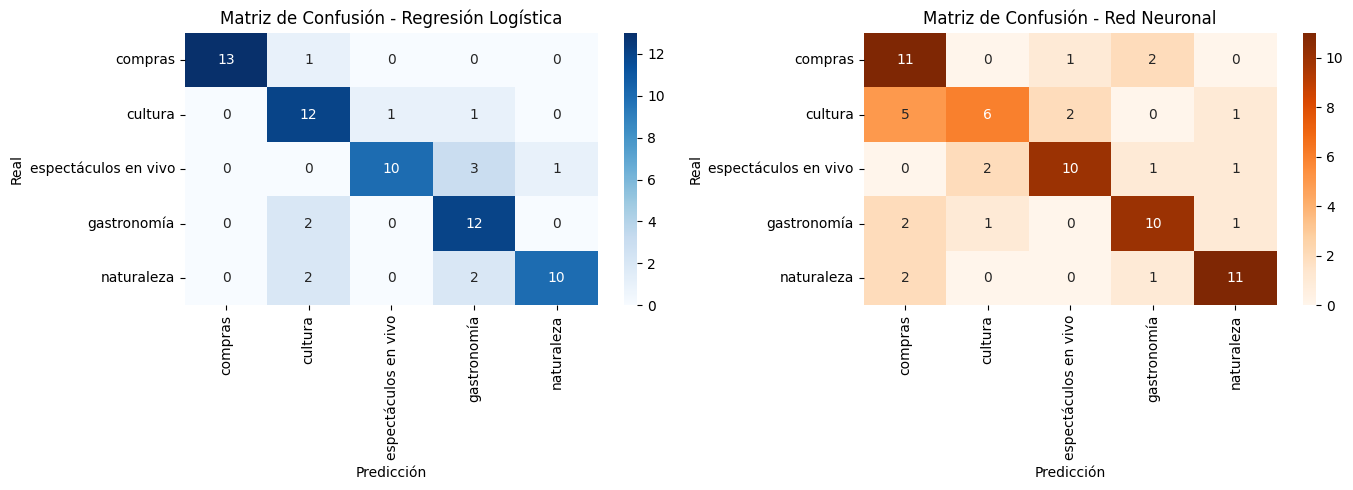

In [ ]:
# Matriz de confusión RN
cm_rn = confusion_matrix(y_true_labels, y_pred_labels)

# Matriz de confusión RL
cm_rl = confusion_matrix(yte_root, y_pred_root)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_rl, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_root.classes_,
            yticklabels=label_encoder_root.classes_,
            ax=axes[0])
axes[0].set_title("Matriz de Confusión - Regresión Logística")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_rn, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder_root.classes_,
            yticklabels=label_encoder_root.classes_,
            ax=axes[1])
axes[1].set_title("Matriz de Confusión - Red Neuronal")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Red Neuronal
print("\n📋 Reporte RN:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder_root.classes_, digits=3))

# Regresión Logística
print("\n📋 Reporte RL:")
yte_root_enc = label_encoder_root.transform(yte_root)
y_pred_root_enc = label_encoder_root.transform(y_pred_root)
print(classification_report(yte_root_enc, y_pred_root_enc, target_names=label_encoder_root.classes_, digits=3))



📋 Reporte RN:
                      precision    recall  f1-score   support

             compras      0.550     0.786     0.647        14
             cultura      0.667     0.429     0.522        14
espectáculos en vivo      0.769     0.714     0.741        14
         gastronomía      0.714     0.714     0.714        14
          naturaleza      0.786     0.786     0.786        14

            accuracy                          0.686        70
           macro avg      0.697     0.686     0.682        70
        weighted avg      0.697     0.686     0.682        70


📋 Reporte RL:
                      precision    recall  f1-score   support

             compras      1.000     0.929     0.963        14
             cultura      0.706     0.857     0.774        14
espectáculos en vivo      0.909     0.714     0.800        14
         gastronomía      0.667     0.857     0.750        14
          naturaleza      0.909     0.714     0.800        14

            accuracy               

Con el fin de valorar de forma más detallada el rendimiento de ambos modelos, se han comparado sus respectivas matrices de confusión, así como las principales métricas de evaluación.

Por lo que respecta a la matriz de confusión, el modelo de regresión logística muestra un comportamiento más preciso, con una mayor tasa de aciertos en varias de las categorías evaluadas.

En concreto, alcanza una clasificación correcta de 13 de las 14 instancias en la clase "compras", y 12 de 14 en "cultura". La clase "espectáculos en vivo" es clasificada correctamente en 10 ocasiones, con los errores restantes principalmente redistribuidos entre "gastronomía" y "naturaleza".

Las clases "gastronomía" y "naturaleza" presentan también buenos resultados  con 12 y 10 aciertos respectivamente.

Por su parte, la red neuronal multicapa muestra un comportamiento más disperso. A pesar de mantener una tasa aceptable de aciertos en "espectáculos en vivo" (10 de 14) y "naturaleza" (11 de 14), comete errores significativos en las categorías más propensas al solapamiento semántico. En el caso de "cultura", por ejemplo, el modelo logra tan solo 6 aciertos sobre 14 instancias, y redistribuye el resto hacia "compras", "espectáculos" y "naturaleza".

Asimismo, si bien mejora ligeramente el rendimiento en la clase "compras" (11 aciertos frente a los 13 obtenidos por la regresión logística), incurre en más errores en las clases "gastronomía" y "espectáculos en vivo".

Además, se observan errores cruzados entre "gastronomía" y "cultura", un patrón que ya se había anticipado en el análisis exploratorio mediante PCA, en el que ambas clases presentaban cercanía estructural.

En relación con las métricas de evaluación, la regresión logística obtiene una precisión macro de 0.838 y un F1-score macro de 0.817, que refleja un rendimiento equilibrado entre clases.

Por su parte, la red neuronal obtiene una precisión macro de 0.697 y un F1-score macro de 0.682, que confirma su menor capacidad de generalización.

En conclusión, a partir del análisis conjunto de las matrices de confusión y las métricas de evaluación, se concluye que el modelo de regresión logística presenta un rendimiento superior en la clasificación de las cinco categorías raíz.

A pesar de que se partía de la hipótesis de que la red neuronal sería más adecuada para capturar relaciones no lineales entre patrones lingüísticos, en este caso no ha superado al modelo lineal.

Esta diferencia puede atribuirse a la naturaleza relativamente lineal del espacio TF-IDF, así como a las limitaciones del corpus, en cuanto a volumen y variabilidad.


 ### 3. c) Entrenamiento y evaluación de un modelo neuronal con embeddings semánticos contextuales basado en Sentence-BERT para las cinco categorías principales

Como alternativa a las representaciones TF-IDF, se ha explorado el uso de embeddings semánticos contextuales generados a partir de una variante afinada de Sentence-BERT (`hiiamsid/sentence_similarity_spanish_es`), basada en la arquitectura original de BERT, con el fin de mejorar la clasificación de intenciones en las cinco categorías raíz del árbol de decisión.

Este modelo está basado en la arquitectura Transformer, caracterizada por su mecanismo de atención bidireccional que implica mayor comprensión contextual.

No se han utilizado en esta fase las frases correspondientes a subcategorías, pues el objetivo es evaluar la capacidad del modelo para distinguir entre las categorías principales del árbol de decisión.

 Una vez asignadas las etiquetas, se ha generado el embedding contextual correspondiente a cada frase mediante el modelo `hiiamsid/sentence_similarity_spanish_es.`

Después, se han dividido los datos en entrenamiento (80%) y prueba (20%) de forma estratificada, con el objetivo de mantener el equilibrio entre clases.

La red neuronal multicapa diseñada es sencilla, con dos capas ocultas de 20 y 10 neuronas respectivamente, activadas ambas con la función ReLU.

La capa de salida emplea activación `softmax`, adecuada para clasificación multiclase. El modelo ha sido compilado con el optimizador Adam y entrenado durante un máximo de 50 épocas, con un tamaño de lote de 16 y validación directa sobre el conjunto de prueba.

Tras el entrenamiento, se ha evaluado el rendimineto del modelo mediante las principales métricas: precisión, recall y F1-score macro.

In [ ]:
!pip install transformers --quiet


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np


In [ ]:
# --- 1. Definir las categorías raíz ---
root_classes = ["naturaleza", "cultura", "gastronomía", "espectáculos en vivo", "compras"]

# --- 2. Filtrar el corpus: solo frases de las 5 categorías raíz ---
texts_root = []
labels_root = []

for label, frases in examples_dict.items():
    if label in root_classes:
        texts_root.extend(frases)
        labels_root.extend([label] * len(frases))

# --- 3. Cargar modelo
print("Cargando el modelo y generando embeddings para categorías raíz...")
sbert_model = SentenceTransformer("hiiamsid/sentence_similarity_spanish_es")
X_root = sbert_model.encode(texts_root, show_progress_bar=True)

# --- 4. Codificar etiquetas (root) ---
label_encoder_root = LabelEncoder()
y_encoded_root = label_encoder_root.fit_transform(labels_root)
y_categorical_root = to_categorical(y_encoded_root)

# --- 5. División entrenamiento/prueba ---
X_train_root, X_test_root, y_train_root, y_test_root = train_test_split(
    X_root, y_categorical_root, test_size=0.2, stratify=y_categorical_root, random_state=42
)

# --- 6. Definir y entrenar red neuronal (simple como TF-IDF) ---
model_root = Sequential([
    Dense(20, activation='relu', input_shape=(X_root.shape[1],), kernel_initializer='he_normal'),
    Dense(10, activation='relu', kernel_initializer='he_normal'),
    Dense(y_categorical_root.shape[1], activation='softmax')
])

model_root.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Entrenando red neuronal con embeddings (5 clases raíz)...")
model_root.fit(
    X_train_root, y_train_root,
    validation_data=(X_test_root, y_test_root),
    epochs=50,
    batch_size=16,
    verbose=1
)

# --- 7. Evaluación del modelo ---
y_pred_probs = model_root.predict(X_test_root)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_root, axis=1)

print("\n📊 Métricas generales (macro):")
print(f"  - Accuracy:        {accuracy_score(y_true, y_pred):.4f}")
print(f"  - Precision macro: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"  - Recall macro:    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"  - F1-score macro:  {f1_score(y_true, y_pred, average='macro'):.4f}")

print("\n📋 Reporte por clase:")
print(classification_report(y_true, y_pred, target_names=label_encoder_root.classes_, digits=3))

Cargando modelo y generando embeddings para categorías raíz...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

 Entrenando red neuronal con embeddings (5 clases raíz)...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3484 - loss: 1.5242 - val_accuracy: 0.6143 - val_loss: 0.9824
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6297 - loss: 0.7998 - val_accuracy: 0.7571 - val_loss: 0.6232
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8580 - loss: 0.4600 - val_accuracy: 0.9143 - val_loss: 0.4265
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9518 - loss: 0.2990 - val_accuracy: 0.9286 - val_loss: 0.3011
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9788 - loss: 0.1496 - val_accuracy: 0.9143 - val_loss: 0.2630
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9814 - loss: 0.1199 - val_accuracy: 0.9286 - val_loss: 0.2246
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9949 - loss: 0.0727 - val_accuracy: 0.9143 - val_loss: 0.2120
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0487 - val_accuracy: 0.9429 - val_loss: 0.1977
Ep

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

📊 Métricas generales (macro):
  - Accuracy:        0.9429
  - Precision macro: 0.9448
  - Recall macro:    0.9429
  - F1-score macro:  0.9433

📋 Reporte por clase:
                      precision    recall  f1-score   support

             compras      0.929     0.929     0.929        14
             cultura      1.000     0.929     0.963        14
espectáculos en vivo      0.867     0.929     0.897        14
         gastronomía      0.929     0.929     0.929        14
          naturaleza      1.000     1.000     1.000        14

            accuracy                          0.943        70
           macro avg      0.945     0.943     0.943        70
        weighted avg      0.945     0.943     0.943        70



El modelo neuronal entrenado con embeddings semánticos ha ofrecido un rendimiento notablemente superior al observado con representaciones TF-IDF.

Los resultados globales obtenidos sobre el conjunto de prueba muestran una precisión del 94.29 %, con una precisión macro de 0.9448, recall macro de 0.9429 y F1-score macro de 0.9433. Estas métricas indican un rendimiento equilibrado en todas las clases.

En el desglose por clase, se observa que “naturaleza” ha sido clasificada correctamente en todas las instancias (F1 = 1.000), seguida de “cultura” (clase hasta el momento mal clasificada por los modelos anteriores), que presenta una precisión perfecta (1.000) y un recall de 0.929, que implica un F1-score de 0.963.

La clase “espectáculos en vivo” es la única que muestra una ligera caída en precisión (0.867), aunque mantiene un buen recall (0.929).

Las categorías “compras” y “gastronomía” también buenos valores, en torno al 0.93%, en todas las métricas.

En comparación con la red neuronal entrenada sobre representaciones TF-IDF (accuracy del 68.6 % y F1 macro de 0.682), el aumento en el rendimiento es evidente.

Este resultado demuestra que los embeddings contextuales aprenden matices semánticos entre frases, que mejoran la discriminación entre clases con estructuras léxicas similares.

En conclusión, los embeddings dinámicos contextuales no solo aumentan la precisión general del sistema, sino que también reducen la confusión entre clases conceptualmente cercanas.

### 3. d) Clasificación detallada y evaluación con embeddings contextuales de las 15 subcategorías del segundo nivel nodal (más las 5 clases raíz)

A continuación se ha entrenado el mismo modelo neuronal afinado de SBERT, `hiiamsid/sentence_similarity_spanish_es`, para clasificar las intenciones del usuario relacionadas con las 15 subcategorías específicas y las 5 categorías principales del árbol de decisión.

Este modelo está diseñado para su posible empleo en el segundo nivel del flujo jerárquico de CanBot, una vez identificada la categoría raíz, con el objetivo de seleccionar la subopción más adecuada.

Su arquitectura es algo más compleja que la anterior, debido a la mayor dificultad clasificatoria del segundo nivel: una primera capa oculta de 64 neuronas, seguida de una segunda capa de 16, ambas con función de activación ReLU y una capa de salida con activación `softmax`.

Finalmente, se ha procedido a su evaluación mediante las métricas estándar de clasificación: precisión, recall y F1-score macro.

In [ ]:
# --- Paso 1: Corpus y etiquetas para todas las categorías ---
corpus = []
labels = []

for label, frases in examples_dict.items():
    corpus.extend(frases)
    labels.extend([label] * len(frases))

# --- Paso 2: Generar embeddings con modelo SBERT en español ---
print("Cargando modelo SBERT afinado en español...")
sbert_model = SentenceTransformer("hiiamsid/sentence_similarity_spanish_es")
X = sbert_model.encode(corpus, show_progress_bar=True)

# --- Paso 3: Codificación de etiquetas ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# --- Paso 4: División entrenamiento / prueba ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

# --- Paso 5: Red neuronal simple y comparable a TF-IDF ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(16, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Entrenando red neuronal con embeddings contextuales SBERT...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    verbose=1
)

# --- Paso 6: Evaluación ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')

print("\n Métricas generales (macro):")
print(f"  - Accuracy:        {accuracy:.4f}")
print(f"  - Precision macro: {precision_macro:.4f}")
print(f"  - Recall macro:    {recall_macro:.4f}")
print(f"  - F1-score macro:  {f1_macro:.4f}")

print("\nReporte por clase:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=3))

Cargando modelo de embeddings en español...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

 Entrenando red neuronal con embeddings...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1694 - loss: 2.7871 - val_accuracy: 0.3875 - val_loss: 2.0279
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4662 - loss: 1.7705 - val_accuracy: 0.5312 - val_loss: 1.4825
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6484 - loss: 1.1773 - val_accuracy: 0.6000 - val_loss: 1.1740
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7732 - loss: 0.7434 - val_accuracy: 0.6187 - val_loss: 1.0074
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8493 - loss: 0.5557 - val_accuracy: 0.6062 - val_loss: 1.0196
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8527 - loss: 0.5017 - val_accuracy: 0.6125 - val_loss: 0.9968
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8920 - loss: 0.3979 - val_accuracy: 0.6375 - val_loss: 0.9785
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9027 - loss: 0.3310 - val_accuracy: 0.6187 - val_loss: 1.0006
Ep

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

 Métricas generales (macro):
  - Accuracy:        0.6438
  - Precision macro: 0.6751
  - Recall macro:    0.6393
  - F1-score macro:  0.6399

Reporte por clase:
                       precision    recall  f1-score   support

                 arte      0.375     0.500     0.429         6
                carne      1.000     0.833     0.909         6
              compras      0.583     0.500     0.538        14
                costa      0.800     0.667     0.727         6
              cultura      0.412     0.500     0.452        14
       dulces típicos      0.333     0.333     0.333         6
encuentros literarios      0.833     0.833     0.833         6
 espectáculos en vivo      0.818     0.643     0.720        14
          gastronomía      0.765     0.929     0.839        14
             historia      1.000     0.333     0.500         6
             mariscos      0.857     1.000     0.923         6
             modernos      0.800     0.667

Los resultados de la evaluación del modelo clasificatorio del segundo nivel reflejan una precisión aceptable pero desigual:

Algunas clases como "teatro", "costa", y "mariscos" presentan una precisión óptima.

Sin embargo, otras, como "parques naturales", "modernos", o "souvenirs", muestran un rendimiento débil, posiblemente debido a solapamiento semántico con otras clases.

La accuracy global es de 0.644, con un F1-Macro promedio de 0.640, valores que reflejan que, aunque el modelo clasifica correctamente algunas categorías, todavía falla en distinguir con precisión ciertas clases.

Esta caída en las métricas es lógica, pues, en este caso, la clasificación entre 20 clases distintas aumenta notablemente la complejidad del problema.



### 3. e)  Sistema híbrido de clasificación jerárquica y contextual con RL y SBERT afinado

Para esta fase del sistema CanBot, se ha desarrollado un flujo conversacional jerárquico basado en el árbol de decisiones definido previamente, que integra de forma híbrida técnicas clásicas de clasificación con enfoques contemporáneos de representación semántica contextual.

En el nodo raíz, encargado de interpretar la intención general del usuario entre las cinco categorías principales, se  ha empleado el modelo de regresión logística previamente entrenado con representaciones TF-IDF. Este modelo ofrece buena relación precisión-eficiencia.

En los casos en los que la confianza del modelo clásico cae por debajo del umbral de confianza de 0.6, el sistema activa un segundo modelo de respaldo basado en redes neuronales, alimentado por embeddings generados mediante el modelo `hiiamsid/sentence_similarity_spanish_es`.

Esta arquitectura, basada en Transformers encoder, permite capturar relaciones contextuales complejas entre palabras, por lo que es adecuado para comprender frases no literales.

En los niveles inferiores del árbol, es decir, en la clasificación de subcategorías específicas, se emplea exclusivamente el modelo neuronal con embeddings contextuales, entrenado con todas las etiquetas, incluidas las subcategorías del dominio.

Este enfoque híbrido y jerárquico adapta dinámicamente la estrategia de clasificación en función del nivel del árbol y la claridad de la entrada.

De este modo, CanBot combina la eficacia de los modelos lineales en contextos controlados con la flexibilidad de los neuronales basados en embeddings contextuales en situaciones más ambiguas y proporciona una experiencia conversacional natural.

In [ ]:
def classify_root(user_input, clf_root, vectorizer, model_root, label_encoder_root, sbert_model, threshold=0.6):
    probs_rl = clf_root.predict_proba(vectorizer.transform([user_input]))[0]
    pred_rl, conf_rl = clf_root.classes_[probs_rl.argmax()], probs_rl.max()

    if conf_rl >= threshold:
        print(f"\n📊 RL detecta: {pred_rl} (confianza={conf_rl:.2f})")
        return pred_rl

    probs_sbert = model_root.predict(sbert_model.encode([user_input]))[0]
    return label_encoder_root.inverse_transform([probs_sbert.argmax()])[0]

def classify_subcat(user_input, model, label_encoder, sbert_model, opciones_validas):
    user_input_clean = user_input.strip().lower()
    if user_input_clean in map(str.lower, opciones_validas):
        print(f"✔️ Coincidencia exacta: {user_input_clean}")
        return user_input_clean

    probs_sbert = model.predict(sbert_model.encode([user_input]))[0]
    pred_sbert = label_encoder.inverse_transform([probs_sbert.argmax()])[0]

    if pred_sbert in opciones_validas:
        return pred_sbert

    print("❌ No se pudo interpretar tu intención.")
    return None

def run_chatbot_recursive(node, nivel, clf_root, vectorizer, model_root, label_encoder_root,
                          model_subcat, label_encoder_subcat, sbert_model, threshold=0.6):
    if isinstance(node, str):
        print("\n✅", node[len("recomienda:"):].strip() if node.lower().startswith("recomienda:") else node)
        return

    options = node.get("options", {})
    user_input = input(f"\n{node['question']} ({' / '.join(options)}): ")

    classify_fn = classify_root if nivel == 0 else classify_subcat
    pred = classify_fn(user_input, *(clf_root, vectorizer, model_root, label_encoder_root, sbert_model, threshold)
                       if nivel == 0 else (model_subcat, label_encoder_subcat, sbert_model, list(options)))

    if pred in options:
        run_chatbot_recursive(options[pred], nivel + 1, clf_root, vectorizer, model_root, label_encoder_root,
                              model_subcat, label_encoder_subcat, sbert_model, threshold)
    else:
        print("❗ Inténtalo de nuevo usando las opciones sugeridas.")
        run_chatbot_recursive(node, nivel, clf_root, vectorizer, model_root, label_encoder_root,
                              model_subcat, label_encoder_subcat, sbert_model, threshold)

print("\n🗺️ Hola, soy CanBot, tu guía turístico por Cantabria 🏞️")
run_chatbot_recursive(decision_tree, 0, clf_root, vectorizer, model_root, label_encoder_root,
                      model, label_encoder, sbert_model)



🗺️ Hola, soy CanBot, tu guía turístico por Cantabria 🏞️

¿Qué tipo de experiencia te gustaría vivir en Cantabria? (naturaleza / cultura / gastronomía / espectáculos en vivo / compras): pasear en una playa salvaje
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

¿Prefieres montaña, costa o parques naturales? (montaña / costa / parques naturales): la brisa marina
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step

✅ Surf en Somo con tabla alquilada


 ### 3. f) Breve reflexión sobre qué aporta la red neuronal frente al método lineal.

Si bien el modelo de regresión logística con representaciones TF-IDF ha mostrado un buen rendimiento para clasificar las intenciones de un usuario en el primer nivel de decisión, debido a su diseño lineal, su capacidad se limita cuando las frases son ambiguas o el número de categorías aumenta (es decir, cuando la estructura del dataset no es separable linealmente).

Dado que las funciones de activación de una red neuronal transforman el espacio para modelar relaciones no lineales, se partía de la hipótesis de que la red neuronal simple obtendría mejores métricas que la regresión logística en el primer nivel categorial.

Sin embargo, los resultados obtenidos con la red neuronal entrenada sobre representaciones TF-IDF no han superado a los del modelo lineal, probablemente por el tamaño del dataset, cuya representación vectorial es insuficiente para una red neuronal.

En contraste, se ha observado que el empleo de embeddings semánticos dinámicos  basados en una arquitectura Transformer (como SBERT afinado en español), capacita a la red neuronal para captar matices de intención y contexto que escapan a las representaciones tradicionales TF-IDF y que, incluso, se clasifican con relativa precisión 20 clases.

De este modo, se concluye que el verdadero potencial de la red neuronal se despliega con los embeddings contextuales como entradas informativas.

 ## Fase 4: Integración del chatbot CantBot con un Large Language Model (LLM) para interpretar entradas ambiguas o difíciles en nodos específicos

A pesar de que la red neuronal entrenada con embeddings contextuales (fine-tuned de SBERT en español) comprende las intenciones no literales del usuario, para que la interacción con CanBot sea totalmente fluida se recomienda entrenar un modelo generativo de lenguaje.

Por este motivo, en esta sección se afina y entrena el LLM (Large Language Model), basado en la arquitectura Transformer decoder, `unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit`, con el fin de crear recomendaciones personalizadas en el segundo nivel jerárquico de CanBot, así como en aquellos casos en los que el modelo del primer nivel (bien sea el de regresión logística, bien el afinado de SBERT) no identifique la entrada del usuario.


 ### 4. a) Instalación de dependencias y elección del modelo de LLM para afinado

Despues de instalarse las dependencias necesarias para el ajuste fino (fine-tuning) de un modelo de lenguaje grande (LLM), se ha optado por Meta-Llama 3.1-8B-Instruct, del modelo instructivo LLaMA 3.1 (de 8B parámetros, optimizada mediante bitsandbytes), por su equilibrio entre rendimiento y eficiencia computacional, frente a alternativas mayores como LLaMA 70B o menores como Gemma.

In [ ]:
%%capture
!pip install --quiet --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft unsloth trl unsloth_zoo sentencepiece datasets


In [ ]:
from unsloth import FastLanguageModel
import torch
from datasets import Dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:

# Al inicio del notebook o script
MODEL_NAME = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"
MAX_SEQ_LENGTH = 1024
LOAD_IN_4BIT = True

# Carga del modelo
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=LOAD_IN_4BIT,
)


==((====))==  Unsloth 2025.6.1: Fast Llama patching. Transformers: 4.52.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

### 4. b) Prueba del modelo base

Antes de proceder con el ajuste fino del LLM, se ha realizado una evaluación inicial del modelo base en su versión original, configurado con la plantilla de formato conversacional `llama-3.1`, a través de un sistema de mapeo automático de nombres.



In [ ]:
# %%
# Mapeo modelo → chat_template
TEMPLATE_MAP = {
    "Llama-3.1":     "llama-3.1",
    "Llama-3.2":     "llama-3.1",
    "Meta-Llama-3.1":"llama-3.1",
    "Mistral-Small":"mistral",
    "Phi-3.5-mini":  "phi3",

}

# Extraer correctamente "Meta-Llama-3.1" desde el nombre del modelo
model_name_full = MODEL_NAME.split("/")[1]  # ej. Meta-Llama-3.1-8B-Instruct-bnb-4bit
short = "-".join(model_name_full.split("-")[:3])  # Resultado: "Meta-Llama-3.1"
template = TEMPLATE_MAP.get(short, "llama-3.1")

from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(tokenizer, chat_template=template)

from unsloth import FastLanguageModel
FastLanguageModel.for_inference(model)  # Asegúrate de activar modo inferencia

import copy
tokenizer_original = copy.deepcopy(tokenizer)

# Ejemplo de pregunta antes del fine-tuning:
mensaje = [{"role": "user", "content": "¿Me recomiendas una ruta en la naturaleza por Cantabria?"}]
inputs = tokenizer_original.apply_chat_template(
    mensaje,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

outputs = model.generate(input_ids=inputs, max_new_tokens=328, temperature=0.3)
print("Respuesta del modelo ORIGINAL (sin afinar):\n")
print(tokenizer_original.decode(outputs[0], skip_special_tokens=True))


NameError: name 'MODEL_NAME' is not defined

### 4. c) Preparación de LORA

Posteriormente, se ha configurado LoRA (Low-Rank Adaptation), técnica de ajuste fino para entrenar grandes modelos de lenguaje (LLMs) mediante una pequeña modificación de parte de sus parámetros, que implica una reducción del uso de memoria y del tiempo de entrenamiento.

In [ ]:
## 2. Preparar LoRA
model = FastLanguageModel.get_peft_model(
        model, r=8, lora_alpha=16, lora_dropout=0.05,
        target_modules = ["q_proj","v_proj","k_proj","o_proj"],
)

### 4. d) Preparación del dataset conversacional para el ajuste fino del modelo

A continuación, se ha creado un dataset conversacional conformado por 150 diálogos usuario-asistente (organizados en 15 categorías con 10 ejemplos cada una) con el objetivo de afinar el modelo LLM para integrarlo en el segundo nivel del sistema CanBo (o bien en el primero, en aquellas situaciones en las que sea necesario resolver ambigüedades).

Cada entrada simula una interacción real, en la que el usuario expresa una intención turística y el modelo responde con una recomendación.

Este conjunto de datos es básico para la personalización del modelo mediante técnicas de ajuste fino, como LoRA.

Mediante la función `get_chat_template()` de la librería `unsloth`, se ha cargado la plantilla correspondiente a `llama-3.1` y se ha definido la función `to_text()` que transforma cada conversación en un texto plano que se utilizará como entrada para el fine-tuning.

Finalmente, se ha aplicado esta transformación al dataset completo mediante `ds.map()`.

In [ ]:
dialogos = [
    # ── naturaleza → montaña
    [{"role":"user","content":"Quiero hacer senderismo en la montaña, plena naturaleza."},
     {"role":"assistant","content":"Haz una ruta por los Picos de Europa y disfruta del aire puro en altura."}],
    [{"role":"user","content":"Estoy buscando paisajes montañosos para explorar."},
     {"role":"assistant","content":"Explora el sendero de Fuente Dé con vistas increíbles desde el teleférico."}],
    [{"role":"user","content":"Planeo una escapada con vistas desde la cima."},
     {"role":"assistant","content":"Recorre el valle de Liébana entre montañas verdes y caminos tranquilos."}],
    [{"role":"user","content":"Me interesa una ruta en zonas elevadas y verdes."},
     {"role":"assistant","content":"Prueba una caminata por el desfiladero de La Hermida, entre roca y río."}],
    [{"role":"user","content":"Quiero respirar aire puro en plena montaña."},
     {"role":"assistant","content":"Sube a Peña Labra, una cumbre accesible con vistas espectaculares."}],
    [{"role":"user","content":"Estoy buscando una ruta de montaña no muy exigente."},
     {"role":"assistant","content":"Haz la Ruta del Cares en su tramo cántabro, ideal para senderismo moderado."}],
    [{"role":"user","content":"Me apetece caminar por zonas rurales entre montañas."},
     {"role":"assistant","content":"Recorre los senderos de Campoo con vistas a picos nevados y praderas."}],
    [{"role":"user","content":"¿Hay alguna zona montañosa con miradores naturales?"},
     {"role":"assistant","content":"Visita el mirador de Santa Catalina en Peñarrubia, con vista sobre el desfiladero."}],
    [{"role":"user","content":"Quiero una escapada tranquila entre montes."},
     {"role":"assistant","content":"Dirígete a Polaciones, un valle escondido entre montañas con pueblos auténticos."}],
    [{"role":"user","content":"¿Qué zona de montaña es buena para una ruta fotográfica?"},
     {"role":"assistant","content":"Los Lagos de Lloroza, accesibles desde Fuente Dé, ofrecen paisajes únicos para fotos."}],

    # ── naturaleza → costa
    [{"role":"user","content":"Busco desconectar en una playa tranquila junto al mar."},
     {"role":"assistant","content":"Relájate en la playa de Langre, ideal para desconectar entre acantilados."}],
    [{"role":"user","content":"Quiero sentir la brisa marina en la costa cántabra."},
     {"role":"assistant","content":"Descubre la costa de Liencres y su parque natural junto al mar."}],
    [{"role":"user","content":"Estoy pensando en una escapada relajante frente al mar."},
     {"role":"assistant","content":"Pasa el día en la playa de Oyambre, perfecta para combinar mar y monte."}],
    [{"role":"user","content":"Me interesa la naturaleza junto a la playa."},
     {"role":"assistant","content":"En Noja puedes disfrutar de playas limpias y rutas costeras entre dunas."}],
    [{"role":"user","content":"Quiero caminar junto al mar al atardecer."},
     {"role":"assistant","content":"Haz el paseo costero entre Comillas y San Vicente con vistas impresionantes."}],
    [{"role":"user","content":"Busco calas escondidas en la costa cántabra."},
     {"role":"assistant","content":"Explora las calas de Cueto en Santander, tranquilas y poco frecuentadas."}],
    [{"role":"user","content":"Estoy buscando playas naturales sin urbanizar."},
     {"role":"assistant","content":"La playa de Berria, en Santoña, es extensa, virgen y rodeada de naturaleza."}],
    [{"role":"user","content":"Quiero hacer una ruta de senderismo junto al mar."},
     {"role":"assistant","content":"Sigue el sendero de la Costa Quebrada para disfrutar de acantilados y fósiles."}],
    [{"role":"user","content":"Me apetece un picnic con vistas al mar."},
     {"role":"assistant","content":"En el Parque de la Naturaleza de Cabárceno hay zonas con vistas panorámicas al Cantábrico."}],
    [{"role":"user","content":"¿Qué playa es buena para disfrutar de la naturaleza sin aglomeraciones?"},
     {"role":"assistant","content":"La playa de Valdearenas, en Liencres, es ideal por su amplitud y entorno natural."}],

    #  ── naturaleza → parques naturales
    [{"role":"user","content":"Quiero caminar por pasarelas de madera en un entorno natural cuidado."},
     {"role":"assistant","content":"El Parque Natural de los Collados del Asón te sorprenderá con cascadas y silencio."}],
    [{"role":"user","content":"Busco una zona tranquila para observar aves y fauna local."},
     {"role":"assistant","content":"Pasea por el Parque de las Dunas de Liencres entre marismas y pinares."}],
    [{"role":"user","content":"Estoy buscando un parque natural sin aglomeraciones."},
     {"role":"assistant","content":"Recorre el Parque Natural Saja-Besaya con sus bosques frondosos y rutas tranquilas."}],
    [{"role":"user","content":"Me interesa una escapada a un espacio protegido."},
     {"role":"assistant","content":"Visita el humedal de Alday, perfecto para observar aves sin aglomeraciones."}],
    [{"role":"user","content":"¿Qué parque natural ofrece rutas fáciles para familias?"},
     {"role":"assistant","content":"El parque de Oyambre tiene senderos accesibles entre dunas y bosque costero."}],
    [{"role":"user","content":"Quiero un plan tranquilo entre árboles y senderos naturales."},
     {"role":"assistant","content":"Explora los hayedos del Parque de Saja-Besaya, perfectos para una caminata relajada."}],
    [{"role":"user","content":"Busco un parque con áreas para picnic en plena naturaleza."},
     {"role":"assistant","content":"El Parque Natural de Peña Cabarga tiene miradores y zonas de descanso ideales para comer al aire libre."}],
    [{"role":"user","content":"Estoy interesado en ver cascadas o saltos de agua."},
     {"role":"assistant","content":"En los Collados del Asón puedes visitar el nacimiento del río Asón, una impresionante cascada natural."}],
    [{"role":"user","content":"¿Dónde puedo caminar entre bosques y ríos?"},
     {"role":"assistant","content":"El Parque de Ucieda ofrece rutas junto al río Bayones, rodeadas de robles y castaños."}],
    [{"role":"user","content":"Quiero desconectar en un entorno verde y protegido."},
     {"role":"assistant","content":"El Parque de las Marismas de Santoña, Victoria y Joyel es un oasis natural con senderos y avistamiento de aves."}],

    # ── cultura → historia
    [{"role":"user","content":"Me gustaría hacer una ruta guiada por sitios históricos."},
     {"role":"assistant","content":"Haz un recorrido histórico por Santillana del Mar y sus calles empedradas."}],
    [{"role":"user","content":"Estoy interesado en conocer la historia cántabra."},
     {"role":"assistant","content":"Explora el castillo de Argüeso para conocer la Edad Media en Cantabria."}],
    [{"role":"user","content":"Quiero visitar un pueblo con valor histórico."},
     {"role":"assistant","content":"Visita el yacimiento romano de Julióbriga en Retortillo."}],
    [{"role":"user","content":"Busco aprender sobre el patrimonio local."},
     {"role":"assistant","content":"El Museo de Prehistoria y Arqueología de Santander guarda vestigios únicos de la región."}],
    [{"role":"user","content":"Me interesa una experiencia que mezcle historia y paisaje."},
     {"role":"assistant","content":"La villa romana de Camesa-Rebolledo combina restos arqueológicos y entorno rural."}],
    [{"role":"user","content":"¿Dónde puedo conocer la historia minera de la región?"},
     {"role":"assistant","content":"El parque de la minería de Reocín ofrece una mirada al pasado industrial cántabro."}],
    [{"role":"user","content":"Busco una excursión cultural con ruinas antiguas."},
     {"role":"assistant","content":"Las ruinas de la iglesia de San Vicente de Argüeso están cargadas de historia y leyenda."}],
    [{"role":"user","content":"Quiero saber más sobre la prehistoria en Cantabria."},
     {"role":"assistant","content":"Las cuevas de El Castillo en Puente Viesgo albergan arte rupestre Patrimonio Mundial."}],
    [{"role":"user","content":"Estoy planeando una visita educativa sobre el pasado de Cantabria."},
     {"role":"assistant","content":"En el centro de interpretación de la neocueva de Altamira aprenderás sobre la vida paleolítica."}],
    [{"role":"user","content":"¿Hay fortalezas medievales bien conservadas para visitar?"},
     {"role":"assistant","content":"El castillo de San Vicente de la Barquera conserva sus murallas y torres originales."}],

    # ── cultura → arte
    [{"role":"user","content":"Quiero ver arte moderno en Santander."},
     {"role":"assistant","content":"Además del Centro Botín, visita el Espacio Alexandra para arte contemporáneo emergente."}],
    [{"role":"user","content":"Busco un centro artístico visual y contemporáneo."},
     {"role":"assistant","content":"Descubre arte urbano en las calles del centro de Santander con sus murales y grafitis."}],
    [{"role":"user","content":"Estoy interesado en museos con arte actual."},
     {"role":"assistant","content":"Explora el MAS (Museo de Arte de Santander) con colecciones clásicas y modernas."}],
    [{"role":"user","content":"Me interesa una experiencia de arte visual moderno."},
     {"role":"assistant","content":"En Comillas, el Capricho de Gaudí es una joya arquitectónica única."}],
    [{"role":"user","content":"Quiero visitar espacios de creación artística local."},
     {"role":"assistant","content":"El Espacio Espiral en Santander acoge exposiciones de artistas regionales."}],
    [{"role":"user","content":"¿Dónde hay talleres o residencias de artistas?"},
     {"role":"assistant","content":"En la Fundación Botín se organizan residencias artísticas y muestras temporales."}],
    [{"role":"user","content":"Busco una exposición temporal de arte en Cantabria."},
     {"role":"assistant","content":"Consulta la sala de exposiciones del Palacete del Embarcadero, junto a la bahía."}],
    [{"role":"user","content":"Me interesa ver esculturas al aire libre."},
     {"role":"assistant","content":"El paseo marítimo de Santander tiene varias esculturas urbanas de gran formato."}],
    [{"role":"user","content":"Estoy planeando una ruta por arquitectura modernista."},
     {"role":"assistant","content":"La Casa del Indiano en Limpias y El Capricho de Gaudí son paradas imprescindibles."}],
    [{"role":"user","content":"¿Dónde encuentro arte contemporáneo fuera de Santander?"},
     {"role":"assistant","content":"En Castro Urdiales, el Castillo-Faro acoge exposiciones artísticas con vistas al mar."}],

    # ── cultura → tradiciones vivas
    [{"role":"user","content":"Quiero ver tradiciones vivas y cultura popular."},
     {"role":"assistant","content":"Participa en una romería local donde se mezclan gastronomía y bailes populares."}],
    [{"role":"user","content":"Me interesa una fiesta típica y auténtica."},
     {"role":"assistant","content":"No te pierdas las danzas típicas en las fiestas de San Vicente de la Barquera."}],
    [{"role":"user","content":"Busco un evento con danzas tradicionales."},
     {"role":"assistant","content":"Durante el verano, muchos pueblos celebran ferias con bolos cántabros y pasacalles."}],
    [{"role":"user","content":"Estoy buscando cultura rural y trajes típicos."},
     {"role":"assistant","content":"La fiesta de La Vijanera muestra el folclore más ancestral del norte de España."}],
    [{"role":"user","content":"¿Qué hay en verano en los pueblos pequeños?"},
     {"role":"assistant","content":"Muchas aldeas celebran fiestas patronales con procesiones y bailes tradicionales."}],
    [{"role":"user","content":"Quiero ver algo típico pero diferente."},
     {"role":"assistant","content":"Asiste al Día de Cantabria en Cabezón de la Sal para conocer música y vestimenta popular."}],
    [{"role":"user","content":"¿Hay actividades que mezclen tradición y ambiente festivo?"},
     {"role":"assistant","content":"Los concursos de arrastre de bueyes en ferias rurales son únicos y muy populares."}],
    [{"role":"user","content":"Busco un plan cultural pero con ambiente local."},
     {"role":"assistant","content":"Las ferias ganaderas de los valles interiores combinan tradiciones vivas y vida cotidiana."}],
    [{"role":"user","content":"Me interesa cómo se celebra la cultura popular en Cantabria."},
     {"role":"assistant","content":"La Fiesta del Orujo en Potes es un evento que reúne tradición, música y gastronomía local."}],
    [{"role":"user","content":"¿Algún sitio donde se respire lo auténtico de la región?"},
     {"role":"assistant","content":"En Carmona puedes ver festejos con gaitas, bailes montañeses y comidas tradicionales."}],

    #  ── gastronomía → carne
    [{"role":"user","content":"Quiero comer carne a la brasa en Cantabria."},
     {"role":"assistant","content":"Prueba un buen chuletón en el restaurante Asador El Tronky, en el corazón de San Roque."}],
    [{"role":"user","content":"Me interesa un plato típico con carne roja."},
     {"role":"assistant","content":"En Liébana, muchos mesones preparan carne de vaca tudanca a la parrilla."}],
    [{"role":"user","content":"Busco restaurante con buen chuletón local."},
     {"role":"assistant","content":"Ve a Carmona y disfruta de platos tradicionales con carne local cocinada al fuego lento."}],
    [{"role":"user","content":"Estoy buscando una comida contundente con carne cántabra."},
     {"role":"assistant","content":"La Posada del Pas en Ontaneda es famosa por su carne guisada con patatas."}],
    [{"role":"user","content":"¿Dónde se come buena carne de la zona?"},
     {"role":"assistant","content":"En Bárcena Mayor puedes probar guisos caseros con carne de caza en mesones típicos."}],
    [{"role":"user","content":"Quiero probar un plato fuerte típico del interior."},
     {"role":"assistant","content":"En Vega de Pas sirven cocido montañés con chorizo y costilla que reconforta el alma."}],
    [{"role":"user","content":"Me apetece carne a la piedra o parrilla."},
     {"role":"assistant","content":"En Santillana del Mar encontrarás asadores con carne tudanca hecha al momento."}],
    [{"role":"user","content":"¿Alguna recomendación para carnívoros en Cantabria?"},
     {"role":"assistant","content":"En Soba hay cabañas rurales que ofrecen carne de ternera de pasto cocinada en horno de leña."}],
    [{"role":"user","content":"Busco algo típico de montaña, bien sabroso."},
     {"role":"assistant","content":"Prueba la carne de cabrito lechal en zonas como Cabuérniga, una delicia tradicional."}],
    [{"role":"user","content":"Quiero disfrutar de una comida de pueblo con buena carne."},
     {"role":"assistant","content":"Los mesones de Ruente sirven platos generosos con carne de ternera autóctona."}],

    # ── gastronomía → mariscos
    [{"role":"user","content":"Quiero disfrutar de una mariscada en la costa."},
     {"role":"assistant","content":"En Pedreña puedes comer mariscos frescos con vistas a la bahía de Santander."}],
    [{"role":"user","content":"¿Dónde se come buen marisco en Cantabria?"},
     {"role":"assistant","content":"El restaurante El Pescador en Suances ofrece una excelente mariscada cantábrica."}],
    [{"role":"user","content":"Busco productos del mar bien preparados."},
     {"role":"assistant","content":"Prueba las almejas a la marinera en Santoña, una delicia local."}],
    [{"role":"user","content":"Me interesa probar mariscos frescos con vistas."},
     {"role":"assistant","content":"En Laredo, los chipirones rellenos y las gambas al ajillo son imperdibles."}],
    [{"role":"user","content":"¿Algún sitio bueno para comer pulpo o navajas?"},
     {"role":"assistant","content":"En Castro Urdiales hay bares marineros que cocinan pulpo a la brasa como en Galicia."}],
    [{"role":"user","content":"Quiero cenar algo especial con mariscos cerca del mar."},
     {"role":"assistant","content":"Reserva en La Marina en Santoña y prueba su arroz caldoso de bogavante."}],
    [{"role":"user","content":"¿Dónde puedo comer pescado y marisco recién traído?"},
     {"role":"assistant","content":"El puerto de San Vicente de la Barquera tiene restaurantes con género del día."}],
    [{"role":"user","content":"Busco algo informal pero con marisco de calidad."},
     {"role":"assistant","content":"Las marisquerías de Colindres tienen buena calidad sin precios excesivos."}],
    [{"role":"user","content":"Me apetece una comida marinera tradicional."},
     {"role":"assistant","content":"El marmitako de bonito en Laredo es típico y lleno de sabor cantábrico."}],
    [{"role":"user","content":"Quiero comer algo del mar en un entorno bonito y tranquilo."},
     {"role":"assistant","content":"La playa de Trengandín en Noja tiene restaurantes con terraza y marisco fresco."}],

    # ── gastronomía → dulces típicos
    [{"role":"user","content":"Me gustaría probar sobaos pasiegos."},
     {"role":"assistant","content":"Los sobaos de El Macho en Selaya son una referencia de calidad."}],
    [{"role":"user","content":"Busco postres típicos de la región."},
     {"role":"assistant","content":"Visita Vega de Pas y prueba quesadas hechas en horno de leña."}],
    [{"role":"user","content":"¿Dónde encuentro quesadas tradicionales?"},
     {"role":"assistant","content":"En Torrelavega puedes encontrar hojaldres crujientes de receta centenaria."}],
    [{"role":"user","content":"Quiero una experiencia dulce y local."},
     {"role":"assistant","content":"La confitería Casa El Andral es famosa por sus frisuelos de Liébana."}],
    [{"role":"user","content":"¿Conoces alguna pastelería típica de pueblo?"},
     {"role":"assistant","content":"En Selaya, Confitería La Ermita ofrece sobaos y quesadas artesanales desde hace generaciones."}],
    [{"role":"user","content":"Me apetece llevar algo dulce como recuerdo."},
     {"role":"assistant","content":"Los estuches de sobaos pasiegos se venden en aeropuertos y ferias locales."}],
    [{"role":"user","content":"¿Hay dulces típicos con historia en Cantabria?"},
     {"role":"assistant","content":"Las corbatas de Unquera tienen origen familiar y aún se hacen con la receta original."}],
    [{"role":"user","content":"Quiero algo tradicional para acompañar el café."},
     {"role":"assistant","content":"Los palucos de Cabezón de la Sal son perfectos para eso y fáciles de llevar."}],
    [{"role":"user","content":"Busco un postre de esos que solo hacen aquí."},
     {"role":"assistant","content":"Prueba la leche frita al estilo montañés, un postre sencillo pero delicioso."}],
    [{"role":"user","content":"¿Qué dulce me recomiendas que no sea sobao?"},
     {"role":"assistant","content":"La quesada pasiega es suave, cremosa y 100% cántabra. No te la pierdas."}],

    # ── espectáculos en vivo → música
    [{"role":"user","content":"¿Dónde hay conciertos este verano en Cantabria?"},
     {"role":"assistant","content":"Consulta la programación del ciclo Música en Grande en verano."}],
    [{"role":"user","content":"Busco una experiencia musical en vivo y al aire libre."},
     {"role":"assistant","content":"Santander Music Festival reúne a bandas nacionales e internacionales en un entorno costero."}],
    [{"role":"user","content":"Quiero bailar con música en directo en Santander."},
     {"role":"assistant","content":"En Escenario Santander puedes disfrutar de conciertos en directo todo el año."}],
    [{"role":"user","content":"Me interesa un plan con artistas en vivo."},
     {"role":"assistant","content":"La Plaza Porticada ofrece recitales y festivales gratuitos al aire libre."}],
    [{"role":"user","content":"¿Algún concierto gratuito o al aire libre pronto?"},
     {"role":"assistant","content":"Mira el calendario cultural del Ayuntamiento, suelen organizar recitales en plazas céntricas."}],
    [{"role":"user","content":"Busco un sitio para escuchar jazz o música tranquila."},
     {"role":"assistant","content":"En el Rvbicón organizan noches de jazz en un ambiente íntimo y cultural."}],
    [{"role":"user","content":"¿Hay festivales en la playa con música?"},
     {"role":"assistant","content":"El festival Sun & Sound en Loredo mezcla DJs, sol y mar todo el fin de semana."}],
    [{"role":"user","content":"Me apetece algo diferente, con música y ambiente local."},
     {"role":"assistant","content":"Las verbenas de pueblo ofrecen música popular en directo y gastronomía regional."}],
    [{"role":"user","content":"¿Dónde puedo ver bandas emergentes en Cantabria?"},
     {"role":"assistant","content":"Sala Niágara en Santander programa grupos jóvenes del panorama nacional e internacional."}],
    [{"role":"user","content":"Quiero plan musical para una noche de verano."},
     {"role":"assistant","content":"Los conciertos al aire libre en el Centro Botín son una opción perfecta frente a la bahía."}],

    #  ── espectáculos en vivo → teatro
    [{"role":"user","content":"¿Qué obras hay en cartel en Cantabria?"},
     {"role":"assistant","content":"El Palacio de Festivales acoge desde teatro clásico hasta vanguardias escénicas."}],
    [{"role":"user","content":"Me interesa ver una buena representación teatral."},
     {"role":"assistant","content":"Teatro CASYC ofrece obras contemporáneas en un ambiente cercano."}],
    [{"role":"user","content":"Busco una noche de teatro con calidad."},
     {"role":"assistant","content":"En Miriñaque puedes ver propuestas independientes de teatro alternativo."}],
    [{"role":"user","content":"Quiero ver teatro clásico en Santander."},
     {"role":"assistant","content":"Consulta la red de teatros municipales para funciones en pueblos como Torrelavega o Castro."}],
    [{"role":"user","content":"¿Hay funciones para público joven o familiar?"},
     {"role":"assistant","content":"El Café de las Artes programa espectáculos para todas las edades, incluyendo títeres y humor gestual."}],
    [{"role":"user","content":"Me gustaría ver algo experimental o distinto."},
     {"role":"assistant","content":"El ciclo Escena Contemporánea trae propuestas rompedoras al Palacio de Festivales."}],
    [{"role":"user","content":"Busco un teatro pequeño con obras alternativas."},
     {"role":"assistant","content":"El Espacio Espiral apuesta por dramaturgias modernas y cercanas al espectador."}],
    [{"role":"user","content":"¿Alguna obra recomendada esta semana?"},
     {"role":"assistant","content":"Consulta la programación en la web del Palacio de Festivales o en las redes del CASYC."}],
    [{"role":"user","content":"Quiero algo íntimo, con cercanía al actor."},
     {"role":"assistant","content":"El Teatro del Cuervo organiza funciones en salas pequeñas con gran cercanía escénica."}],
    [{"role":"user","content":"¿Dónde hay actividades teatrales en verano?"},
     {"role":"assistant","content":"En los pueblos costeros se hacen representaciones al aire libre dentro de los festivales culturales."}],

    #  ── espectáculos en vivo → encuentros literarios
    [{"role":"user","content":"Me interesa asistir a una lectura o presentación de libros."},
     {"role":"assistant","content":"La UIMP organiza ciclos literarios con autores españoles e internacionales."}],
    [{"role":"user","content":"Busco un evento literario en un café cultural."},
     {"role":"assistant","content":"Librerías como Gil o Estvdio en Santander acogen firmas y presentaciones."}],
    [{"role":"user","content":"Quiero disfrutar de poesía o narrativa en directo."},
     {"role":"assistant","content":"El festival Letras en la Calle celebra la lectura en espacios públicos."}],
    [{"role":"user","content":"Estoy interesado en encuentros con escritores cántabros."},
     {"role":"assistant","content":"En el Ateneo de Santander se programan tertulias literarias y poesía en vivo."}],
    [{"role":"user","content":"¿Hay actividades literarias este mes?"},
     {"role":"assistant","content":"Consulta el ciclo 'Leer el Norte', que organiza charlas, clubs de lectura y firmas con autores del Cantábrico."}],
    [{"role":"user","content":"Me gustaría participar en un taller de escritura."},
     {"role":"assistant","content":"La Biblioteca Central de Cantabria organiza talleres de escritura creativa para adultos y jóvenes."}],
    [{"role":"user","content":"¿Dónde puedo escuchar a autores hablar de sus obras?"},
     {"role":"assistant","content":"En el Centro Cultural Doctor Madrazo hay charlas semanales con escritores invitados."}],
    [{"role":"user","content":"Busco una actividad tranquila, tipo lectura comentada."},
     {"role":"assistant","content":"El Club de Lectura de la Biblioteca Menéndez Pelayo abre inscripciones cada trimestre."}],
    [{"role":"user","content":"¿Hay poesía en vivo en algún rincón cultural?"},
     {"role":"assistant","content":"El ciclo Versos al Paso reúne a poetas locales en bares y cafés de Santander."}],
    [{"role":"user","content":"Me interesa lo literario pero en un ambiente informal."},
     {"role":"assistant","content":"Algunos cafés como La Vorágine mezclan música, libros y encuentros espontáneos con autores."}],

    #  ── compras → tradicionales
    [{"role":"user","content":"Quiero comprar productos típicos cántabros hechos a mano."},
     {"role":"assistant","content":"Compra sobaos, miel y quesadas en los mercados de Potes o Cabezón de la Sal."}],
    [{"role":"user","content":"Me interesa llevarme recuerdos tradicionales de la región."},
     {"role":"assistant","content":"Artesanos en Santillana del Mar venden cerámica cántabra y cestería."}],
    [{"role":"user","content":"¿Dónde hay mercados con artesanía local?"},
     {"role":"assistant","content":"En el mercado de productores de Torrelavega hay embutidos y pan de pueblo."}],
    [{"role":"user","content":"Busco algo clásico, rural y auténtico para regalar."},
     {"role":"assistant","content":"La feria de productos pasiegos en Vega de Pas es perfecta para llevar sabor a casa."}],
    [{"role":"user","content":"Quiero llevarme algo hecho por artesanos cántabros."},
     {"role":"assistant","content":"Las ferias de Rionansa y Cabezón ofrecen textiles y piezas talladas a mano."}],
    [{"role":"user","content":"¿Dónde encuentro productos de alimentación tradicional?"},
     {"role":"assistant","content":"En Potes puedes comprar quesos de cabra, mermeladas caseras y orujo artesanal."}],
    [{"role":"user","content":"Busco productos auténticos que no estén en supermercados."},
     {"role":"assistant","content":"Visita tiendas rurales en Liébana donde los productores venden directamente."}],
    [{"role":"user","content":"Me interesa algo con sabor y origen rural."},
     {"role":"assistant","content":"Las alubias de Casar de Periedo y el chorizo casero son muy apreciados."}],
    [{"role":"user","content":"¿Hay algo textil o decorativo de tradición local?"},
     {"role":"assistant","content":"En la zona pasiega puedes encontrar mantas tejidas a mano y piezas de cestería de avellano."}],
    [{"role":"user","content":"Quiero comprar cosas típicas como lo haría un local."},
     {"role":"assistant","content":"En los mercadillos semanales de pueblos como Comillas o Unquera encontrarás productos caseros y tradicionales."}],

    #  ── compras → modernos
    [{"role":"user","content":"Me interesa el diseño local contemporáneo en Santander."},
     {"role":"assistant","content":"Santander cuenta con tiendas de diseño joven como Moaré o Monochrome Concept Store."}],
    [{"role":"user","content":"Quiero comprar objetos modernos con esencia cántabra."},
     {"role":"assistant","content":"La galería DelSolST en Suances combina arte contemporáneo y objetos decorativos."}],
    [{"role":"user","content":"Busco regalos creativos de diseño actual."},
     {"role":"assistant","content":"Tiendas boutique en la calle Hernán Cortés ofrecen moda y diseño local."}],
    [{"role":"user","content":"¿Dónde hay tiendas con artículos modernos y originales?"},
     {"role":"assistant","content":"Explora el espacio Río de la Pila para encontrar diseño independiente cántabro."}],
    [{"role":"user","content":"¿Alguna tienda con ropa o arte diferente?"},
     {"role":"assistant","content":"En Espacio Alexandra hay piezas de arte-objeto, ropa de autor y libros de diseño."}],
    [{"role":"user","content":"Busco decoración o accesorios con estilo actual."},
     {"role":"assistant","content":"En Del Sol Art Shop puedes encontrar cerámica de autor y objetos gráficos modernos."}],
    [{"role":"user","content":"Quiero comprar algo elegante y hecho por diseñadores locales."},
     {"role":"assistant","content":"Las tiendas de la zona de Tetúan tienen joyería contemporánea cántabra."}],
    [{"role":"user","content":"¿Dónde encuentro moda con toque alternativo?"},
     {"role":"assistant","content":"El showroom de artistas de Enclave Santander mezcla ropa de autor y arte joven."}],
    [{"role":"user","content":"Estoy buscando algo para regalar a alguien con gusto por el diseño."},
     {"role":"assistant","content":"En Monochrome Concept Store encontrarás desde cuadernos creativos hasta objetos de papelería artística."}],
    [{"role":"user","content":"Me interesa una tienda de cosas originales, no comerciales."},
     {"role":"assistant","content":"Visita lugares como La Nube en Santander, donde exponen y venden creadores locales emergentes."}],


        #  ── compras → souvenirs
    [{"role":"user","content":"Quiero comprar souvenirs típicos para mis amigos."},
     {"role":"assistant","content":"En Santillana del Mar encontrarás souvenirs hechos a mano con motivos marinos."}],
    [{"role":"user","content":"Busco recuerdos pequeños pero auténticos de Cantabria."},
     {"role":"assistant","content":"Tiendas de comestibles artesanales ofrecen packs de dulces típicos como regalo."}],
    [{"role":"user","content":"¿Dónde puedo encontrar imanes o llaveros regionales?"},
     {"role":"assistant","content":"Puedes comprar llaveros, tazas o camisetas con frases cántabras en el centro de Santander."}],
    [{"role":"user","content":"Me interesa llevarme detalles sencillos que representen la zona."},
     {"role":"assistant","content":"Los museos y centros de interpretación suelen tener tiendas con recuerdos temáticos."}],
    [{"role":"user","content":"Busco algo económico pero con identidad local."},
     {"role":"assistant","content":"En los mercados de Comillas y Noja encontrarás chapas, postales y productos con estética cántabra."}],
    [{"role":"user","content":"¿Hay recuerdos con frases o símbolos típicos?"},
     {"role":"assistant","content":"Las tiendas turísticas del Paseo Pereda venden productos con el logo de Cantabria Infinita."}],
    [{"role":"user","content":"Quiero llevar un recuerdo a alguien que no conoce Cantabria."},
     {"role":"assistant","content":"Los kits con sobaos, imán y folleto turístico son perfectos para regalar una primera impresión."}],
    [{"role":"user","content":"Me gustaría algo con imagen de la naturaleza local."},
     {"role":"assistant","content":"Los calendarios con fotos del paisaje cántabro están en muchas librerías turísticas."}],
    [{"role":"user","content":"¿Dónde puedo comprar regalos prácticos con identidad cántabra?"},
     {"role":"assistant","content":"Algunas tiendas venden tote bags, tazas y agendas decoradas con ilustraciones locales."}],
    [{"role":"user","content":"Busco algo pequeño, fácil de llevar, pero que sea muy cántabro."},
     {"role":"assistant","content":"Las cajitas de madera pintadas a mano con motivos rurales se venden en ferias y museos."}],
]

ds = Dataset.from_list([{"conversations": d} for d in dialogos])


# 2) NO ejecutes standardize_sharegpt()
# ds = standardize_sharegpt(ds)   <-- ¡quítalo!

# 3) Aplica la plantilla
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(tokenizer, chat_template="llama-3.1")



def to_text(batch):
    batch["text"] = [
        tokenizer.apply_chat_template(
            conv,
            tokenize=False,
            add_generation_prompt=False,  # <- importante
            system_prompt=None            # <- evita insertar "system"
        )
        for conv in batch["conversations"]
    ]
    return batch


ds = ds.map(to_text, batched=True, remove_columns=["conversations"])

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Después, se ha verificado que el datset se haya convertido correctamente a texto plano con el formato conversacional basado en la plantilla llama-3.1.



In [ ]:
print(ds[0]["text"])


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Quiero hacer senderismo en la montaña, plena naturaleza.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Haz una ruta por los Picos de Europa y disfruta del aire puro en altura.<|eot_id|>


Antes de realizar cualquier fine-tuning sobre el modelo LLM, se ha realizado una copia profunda del modelo y el tokenizador original mediante `copy.deepcopy()` para conservar una versión inalterada para comparaciones posteriores.

In [ ]:
import copy

model_original = copy.deepcopy(model)
tokenizer_original = copy.deepcopy(tokenizer)

### 4. e) Ajuste fino supervisado de LLaMA 3.1

La celda inferior inicia un proceso de ajuste fino supervisado sobre el modelo de lenguaje LLaMA 3.1  basado en arquitectura Transformer.

En primer lugar, se ha proporcionado el tokenizador asociado y el conjunto de datos, para extraer las secuencias de texto a través del campo denominado "text".

A continuación, mediante una instancia de `TrainingArguments`, se han configurado los parámetros de optimización del entrenamiento:

-un tamaño de lote de cuatro ejemplos por dispositivo.

-un máximo de 260 pasos de entrenamiento.

-una tasa de aprendizaje inicial de 2x10⁻⁴.

-una activación de precisión mixta en punto flotante de 16 bits para reducir el consumo de memoria y acelerar el cómputo.

-un registro de métricas cada diez iteraciones.

Con `DataCollatorForSeq2Seq` se han agrupado dinámicamente las muestras en cada lote, con el tokenizado necesario y se han generado tensores de PyTorch como entrada del modelo.

Finalmente, con la llamada a `trainer.train()` se ha activado el bucle de entrenamiento.


In [ ]:

from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ds,
    dataset_text_field="text",
    args=TrainingArguments(
        per_device_train_batch_size=4,
        max_steps=260,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=10,
        output_dir="outputs",
    ),
    data_collator=DataCollatorForSeq2Seq(tokenizer, return_tensors="pt"),
)
trainer.train()

Unsloth: Tokenizing ["text"]:   0%|          | 0/150 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 150 | Num Epochs = 7 | Total steps = 260
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 6,815,744/8,000,000,000 (0.09% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rebecapatrici (rebecapatrici-universidad-de-la-rioja) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,3.277000
20,1.601000
30,1.362400
40,1.278800
50,1.108800
60,1.037300
70,0.971900
80,0.888100
90,0.789400
100,0.750700


Unsloth: Will smartly offload gradients to save VRAM!


TrainOutput(global_step=260, training_loss=0.8127009492654067, metrics={'train_runtime': 456.8449, 'train_samples_per_second': 2.276, 'train_steps_per_second': 0.569, 'total_flos': 3571652286038016.0, 'train_loss': 0.8127009492654067})

Tras el afinamiento del modelo `unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit`, se ha realizado una pequeña prueba para comprobar cómo responde a una entrada concreta del usuario.


In [ ]:
FastLanguageModel.for_inference(model)
msg = [{"role": "user", "content": "Quiero una ruta tranquila de montaña con buen paisaje."}]
inputs = tokenizer.apply_chat_template(msg, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
out = model.generate(inputs, max_new_tokens=160)
print(tokenizer.decode(out[0], skip_special_tokens=True))

system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Quiero una ruta tranquila de montaña con buen paisaje.assistant

Haz una ruta por los valles de Peñarrubia y Puenteluna, rodeados de montañas y ríos cristalinos.


### 4. f) Comparación de respuestas antes y después del fine-tuning

Para evaluar el impacto del fine-tuning, se ha realizado una prueba cualitativa con el fin de comparar las respuestas generadas por el modelo `Meta-Llama-3.1-8B-Instruct` antes y después del ajuste supervisado.

In [ ]:
FastLanguageModel.for_inference(model_original)
FastLanguageModel.for_inference(model)

# --- Prompt de prueba ---
prompt = "Busco una excursión para relajarme en la costa"
msg = [{"role": "user", "content": prompt}]

# --- Respuesta modelo original ---
inputs_orig = tokenizer_original.apply_chat_template(msg, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
out_orig = model_original.generate(inputs_orig, max_new_tokens=190, temperature=1.2)
decoded_orig = tokenizer_original.decode(out_orig[0], skip_special_tokens=True)
decoded_orig = decoded_orig.split("assistant")[-1].replace("user", "").strip()
print("Respuesta del modelo ORIGINAL (sin afinar):")
print(f"Usuario: {prompt}")
print(f"Chatbot: {decoded_orig}")

print("\n" + "="*60 + "\n")

# --- Respuesta modelo afinado ---
inputs_af = tokenizer.apply_chat_template(msg, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
out_af = model.generate(inputs_af, max_new_tokens=190, temperature=0.7)
decoded_af = tokenizer.decode(out_af[0], skip_special_tokens=True)
decoded_af = decoded_af.split("assistant")[-1].replace("user", "").strip()
print("Respuesta del modelo AFINADO:")
print(f"Usuario: {prompt}")
print(f"Chatbot: {decoded_af}")


Respuesta del modelo ORIGINAL (sin afinar):
Usuario: Busco una excursión para relajarme en la costa
Chatbot: Hay muchas opciones de excursión en la costa para relajarte. Aquí te presento algunas ideas:

1. **Excursión de playa**: Elige un destino con una playa hermosa y tranquila, como la Costa Brava en España, la Riviera Francesa, la Costa Azul en Italia o las playas de Florida en EE. UU.
2. **Fin de semana en un balneario**: Busca un balneario con una atmósfera relajante, como un spa o un resort con piscinas y tratamiento de wellness.
3. **Crucero por la costa**: Disfruta de la majestuosidad del mar y la costa desde el barco, con opciones de excursiones en tierra y disfrutes como la cena en cubierta.
4. **Paseo por un arrecife**: Descubre la biodiversidad submarina en


Respuesta del modelo AFINADO:
Usuario: Busco una excursión para relajarme en la costa
Chatbot: La playa de Oyambre tiene calas tranquilas perfectas para desconectar.


De este modo, se ha empleado una entrada ambigua formulada por el usuario con el fin de comparar el comportamiento del modelo antes y después del ajuste fino.

Se observa que las respuestas generadas por el modelo original (sin fine-tuning) son genéricas o referidas a contextos ajenos al dominio turístico de Cantabria, con menciones a la Costa Brava o a arrecifes inexistentes en la región del norte peninsular.

En cambio, tras el fine-tuning, el modelo genera una sola respuesta, específica y alineada con las subcategorías del árbol de decisión.


### 4. g) Integración del LLM en el árbol de decisiones

####4.g) 1. Creación de la función del segundo nivel

A continuación, se ha creado la función `nodo_recomendar_destino(intencion, modelo, tokenizer)`.

Esta función se activa, bien cuando la entrada del usuario corresponde a una de las 15 subcategorías definidas en el árbol de decisión (segundo nivel jerárquico), bien cuando el modelo de regresión logística o el afinado SBERT no identifican con suficiente confianza la intención principal del usuario.

La función toma como entrada una intención expresada en lenguaje natural y genera una recomendación textual a través del LLM.

El *prompt* se construye dinámicamente en función de la intención, y se convierte en una secuencia compatible con el modelo mediante el uso de una plantilla conversacional (`chat_template`) específica.

A continuación, el modelo genera una respuesta, que es decodificada y procesada para su uso directo dentro del flujo de diálogo.

Esta función permite simular una generación contextualizada, que refuerza la flexibilidad del sistema y mejora la naturalidad de las respuestas.



In [ ]:
FastLanguageModel.for_inference(model)  # activar modo generación

def nodo_recomendar_destino(intencion, modelo, tokenizer):
    prompt = f"Quiero una recomendación turística en Cantabria para relajarme en la naturaleza: {intencion}"
    mensaje = [{"role": "user", "content": prompt}]
    inputs = tokenizer.apply_chat_template(
        mensaje, tokenize=True, add_generation_prompt=True, return_tensors="pt"
    ).to("cuda")
    outputs = modelo.generate(input_ids=inputs, max_new_tokens=264, temperature=0.9)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    decoded = decoded.split("assistant")[-1].replace("user", "").strip()
    return decoded

# Ejemplo de uso:
respuesta = nodo_recomendar_destino("costa", model, tokenizer)
print(f"Chatbot: {respuesta}")



Chatbot: Ve a la playa de Trengandín en Noja, ideal para respirar mar y naturaleza sin aglomeraciones.


### 4. h) Eavaluacion cualitativa de la clasificación y calidad de la respuesta del modelo `unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit` con frases ambiguas

Para evaluar la capacidad del modelo LLM afinado para interpretar intenciones ambiguas, se ha diseñado una prueba cualitativa con cinco oraciones, correspondiente respectivamente a cada una de las cinco clases principales, mediante la función antes mencionada, `nodo_recomendar_destino(intencion, modelo, tokenizer)`.


In [ ]:
FastLanguageModel.for_inference(model)  # activar modo generación

def nodo_recomendar_destino(intencion, modelo, tokenizer):
    prompt = f"Quiero una recomendación turística en Cantabria para este tipo de plan: {intencion}"
    mensaje = [{"role": "user", "content": prompt}]
    inputs = tokenizer.apply_chat_template(
        mensaje, tokenize=True, add_generation_prompt=True, return_tensors="pt"
    ).to("cuda")
    outputs = model.generate(input_ids=inputs, max_new_tokens=264, temperature=0.9)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    decoded = decoded.split("assistant")[-1].replace("user", "").strip()
    return decoded

# Frases ambiguas para probar el LLM
frases_ambiguas = [
    "Quiero disfrutar de algo relajante y salvaje a la vez",
    "Ganas de disfrutar con un buen servicio",
    "Recuerdos para la familia",
    "Me encanta lo abstracto",
    "Un festival en verano"
]

print("🧪 Probando respuestas del modelo LLM con frases ambiguas:\n")

for frase in frases_ambiguas:
    respuesta = nodo_recomendar_destino(frase, model, tokenizer)
    print(f"Usuario: {frase}")
    print(f"Chatbot (LLM): {respuesta}\n{'-'*50}\n")


🧪 Probando respuestas del modelo LLM con frases ambiguas:

Usuario: Quiero disfrutar de algo relajante y salvaje a la vez
Chatbot (LLM): Visita el Parque de Urdón y disfruta del aire libre entre los hayedos.
--------------------------------------------------

Usuario: Ganas de disfrutar con un buen servicio
Chatbot (LLM): En Santillana del Mar, visita el Museo de la Minería y respira su ambiente reconfortante.
--------------------------------------------------

Usuario: Recuerdos para la familia
Chatbot (LLM): En Soba, el Parque de la Naturaleza y el Museo de la Tierra tienen piezas interactuales para niños.
--------------------------------------------------

Usuario: Me encanta lo abstracto
Chatbot (LLM): En Soba, el Museo de la Madera y del Papel es un espacio minimalista pero impactante.
--------------------------------------------------

Usuario: Un festival en verano
Chatbot (LLM): El Festival de Música en Ruinas de Comillas es único y atrae a turistas de todo el mundo.
----------

La evaluación cualitativa revela que el modelo LLM afinado interpreta correctamente la intención del usuario, responde de forma contextualizada y genera recomendaciones textuales completas, precisas y coherentes, incluso ante frases ambiguas.

Dado que este modelo combina una excelente comprensión semántica, capacidad de adaptación, riqueza expresiva y generación natural del lenguaje, y considerando que supera en realismo y calidad de respuesta tanto a los enfoques clásicos de Aprendizaje Automático (como la regresión logística), como a modelos de Aprendizaje Profundo (como la red neuronal simple o incluso a modelos basados en la arquitectura Transformer, como SBERT) en tareas de clasificación, se propone su integración en el sistema CanBot como mecanismo principal de generación de respuestas en el segundo nivel jerárquico, así como módulo de respaldo cuando la intención del usuario no pueda clasificarse con certeza en el primer nivel.


### 4. i) Ejemplo de uso de CanBot con clasificación ML y generación LLM

A continuación se ejemplifica el uso de CanBot con el clasificador ML en el primer nivel (puede ser fácilmente sustituido por la red neuronal con embeddings basada en SBERT con las correspondientes modificaciones mínimas).

La función `run_chatbot_llm_direct` implementa la lógica conversacional final del sistema CanBot, que, en este caso, combina la eficiencia de la clasificación basada en Aprendizaje Automático con la capacidad de generación contextual de respuestas mediante un modelo LLM previamente afinado.

En primer lugar, el sistema solicita al usuario que introduzca una experiencia deseada relacionada con el turismo en Cantabria.

Después, se vectoriza la entrada con TF-IDF y, si el umbral de confianza es mayor o igual que 0,6 y la categoría identificada existe entre las opciones del árbol de decisión, el modelo clásico navega por el árbol sin necesidad de invocarse al LLM hasta el siguiente nodo.

En caso contrario, se recurre a `nodo_recomendar_destino` para que el LLM genere una recomendación contextualizada a partir del mensaje del usuario, y finalmente, muestra la respuesta o solicita reformular la entrada si esta queda vacía.

Este enfoque híbrido garantiza eficiencia y precisión en la interpretación de intenciones, incluso ante entradas ambiguas, al tiempo que proporciona una experiencia conversacional fluida y natural.


In [ ]:
def run_chatbot_llm_direct(tree, model, tokenizer, vectorizer, clf_root, threshold=0.6):
    print("\n🗺️ Hola, soy Canbot, tu guía turístico por Cantabria 🏞️")
    user_input = input("\n¿Qué tipo de experiencia estás buscando?: ").strip().lower()

    # --- Nivel 1: Clasificación con regresión logística ---
    X_input = vectorizer.transform([user_input])
    probas = clf_root.predict_proba(X_input)[0]
    pred_index = np.argmax(probas)
    pred_category = clf_root.classes_[pred_index]
    confidence = probas[pred_index]

    if confidence >= threshold and pred_category in tree["options"]:
        # Flujo principal: usar la lógica del árbol sin invocar al LLM
        respuesta = tree["options"][pred_category]
    else:
        # Fallback: LLM genera una recomendación contextual
        respuesta = nodo_recomendar_destino(user_input, model, tokenizer)

    if not respuesta or not respuesta.strip():
        print("Lo siento, no he podido generar una recomendación. ¿Puedes intentar reformular tu idea?")
    else:
        print(f"🤖 {respuesta}")



In [ ]:
run_chatbot_llm_direct(decision_tree, model, tokenizer, vectorizer, clf_root)



🗺️ Hola, soy Canbot, tu guía turístico por Cantabria 🏞️

¿Qué tipo de experiencia estás buscando?: relajarme en un parque natural
🤖 El parque natural de Cueto Pas (Santoña) es ideal para caminar entre pinos y costas limpias.


### 4. j) Evaluación del sistema CanBot en dos niveles: ejemplo con ML/LLM

Con el objetivo de evaluar el comportamiento global del sistema CanBot, se ha elaborado un conjunto de prueba compuesto por quince frases que simulan intenciones variadas expresadas en lenguaje natural.

Cada frase ha sido asociada manualmente a una de las cinco categorías principales del árbol de decisión: "naturaleza", "cultura", "gastronomía", "espectáculos en vivo" y "compras".

Para esta evaluación, se ha utilizado la función `evaluar_chatbot`, diseñada en los dos niveles jerárquicos ya descritos.

Esta función evalúa de forma simple si el sistema reconoce correctamente la intención del usuario y, aunque no mide similitud semántica, permite una primera validación sencilla del sistema.

Los resultados se presentan en tres métricas complementarias:

a) Precisión del clasificador (nivel 1): porcentaje de frases correctamente clasificadas por el modelo elegido (en esta prueba, regresión logística).

b) Recuperación por LLM (nivel 2): porcentaje de frases incorrectamente clasificadas en el nivel 1 pero correctamente resueltas por el LLM.

c) Precisión global combinada: porcentaje total de aciertos sumando ambos niveles.

Como propuesta futura, se recomienda mejorar esta evaluación mediante modelos basados en embeddings para, de esa manera, reflejar la comprensión semántica del modelo LLM.


In [ ]:
test_data = [
    ("naturaleza", "Quiero hacer senderismo en un monte salvaje"),
    ("cultura", "Me interesa visitar algún sitio histórico de Cantabria"),
    ("gastronomía", "¿Dónde puedo comer una buena carne cántabra?"),
    ("espectáculos en vivo", "Quiero ir a un concierto al aire libre, con mucha gente"),
    ("compras", "Busco una tienda donde comprar recuerdos típicos de la región"),

    ("naturaleza", "Ir a una playa virgen"),
    ("cultura", "Me gustaría recorrer museos locales"),
    ("gastronomía", "Busco un restaurante que sirva platos típicos del mar"),
    ("espectáculos en vivo", "¿Dónde puedo ver una obra de teatro interesante?"),
    ("compras", "Estoy buscando un mercado tradicional para comprar artesanías"),

    ("naturaleza", "Deseo practicar kayak en un río natural"),
    ("cultura", "Busco iglesias o edificios históricos en Cantabria"),
    ("gastronomía", "¿Dónde degustar los mejores quesos cántabros?"),
    ("espectáculos en vivo", "Quiero asistir a festivales de música en la zona"),
    ("compras", "Me interesa visitar tiendas de productos locales y regionales")
]


In [ ]:
def evaluar_chatbot(test_data, clf_root, vectorizer, model_llm, tokenizer_llm):
    correctas_n1 = 0
    correctas_n2 = 0
    total = len(test_data)

    for categoria_esperada, frase in test_data:
        # Nivel 1
        X_input = vectorizer.transform([frase])
        pred_n1 = clf_root.predict(X_input)[0]

        if pred_n1 == categoria_esperada:
            correctas_n1 += 1
        else:
            # Generación LLM
            respuesta_llm = nodo_recomendar_destino(frase, model_llm, tokenizer_llm)

            if categoria_esperada.lower() in respuesta_llm.lower():
                correctas_n2 += 1
            else:
                print(f"❌ MAL\nFrase: {frase}\nEsperado: {categoria_esperada}\n"
                      f"Nivel 1 predijo mal: {pred_n1}\n"
                      f"Respuesta LLM: {respuesta_llm}\n")

    aciertos_totales = correctas_n1 + correctas_n2
    print(f"\n✅ Precisión ML (nivel 1): {correctas_n1 / total:.2%}")
    print(f"✅ Precisión recuperación por LLM (nivel 2): {correctas_n2 / total:.2%}")
    print(f"\n🎯 Precisión combinada: {aciertos_totales / total:.2%}")


In [ ]:
evaluar_chatbot(test_data, clf_root, vectorizer, model, tokenizer)


✅ Precisión ML (nivel 1): 100.00%
✅ Precisión recuperación por LLM (nivel 2): 0.00%

🎯 Precisión combinada: 100.00%


La evaluación del sistema CanBot mediante la función `evaluar_chatbot` refleja un rendimiento excelente, con una precisión total del 100 % en el nivel 1 (clasificador basado en regresión logística).

Dado que todas las predicciones han sido correctas en esa fase, no ha sido necesario activar el modelo generativo del nivel 2, por lo que se demuestra la efectividad del sistema en contextos bien definidos.
